# Cross Validation

In [45]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [46]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

Sample no.  Easting  Northing  MassArea  Thickness  [-5,-4)  [-4,-3)  \
0   VF95-06a     3133      9522    417.20         40      0.0     11.0   
1   VF95-08a     1907      8096    312.90         30      1.0     13.0   
2   VF97-20Q     5500      8723    208.60         20      2.0      7.0   
3  VF98-01a3     2665      9054    239.89         23      4.0     13.0   
4   VF98-02a     1154      7735    156.45         15      1.0     12.0   

   [-3,-2)  [-2,-1)  [-1,0)  [0,1)  [1,2)  [2,3)  [3,4)        radius  
0     21.0     22.0    23.0   17.0    4.0    0.0    0.0  10024.179418  
1     19.0     24.0    25.0   16.0    3.0    0.0    0.0   8317.563646  
2     14.0     21.0    26.0   21.0    6.0    1.0    1.0  10312.164128  
3     18.0     21.0    23.0   15.0    3.0    0.0    0.0   9438.068711  
4     19.0     23.0    24.0   17.0    3.0    0.0    0.0   7820.610015

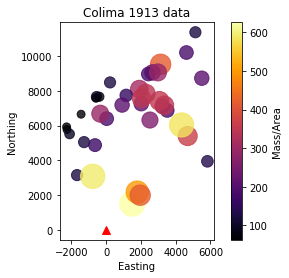

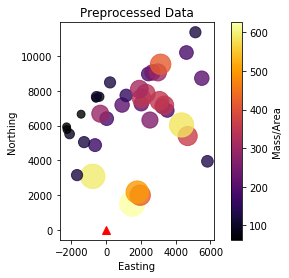

In [47]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [48]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

Easting  Northing  Elevation  MassArea   [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506          0   732.730  23.15290  25.4668  22.2407   
18     1957      1997          0   691.154  21.35410  24.7682  22.4602   
17     1787      2173          0   709.841  21.21370  24.7100  22.4801   
37     -770      3082          0   301.066  13.80220  19.2173  22.1297   
31    -1673      3152          0   149.680   9.51561  14.8613  20.3208   

    [-2,-1)    [-1,0)     [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  15.7304   8.99492   3.44384  0.823464  0.136596  0.010359  2124.861643   
18  16.5434   9.82586   3.90198  0.968656  0.164832  0.012894  2796.043276   
17  16.6062   9.88889   3.93999  0.980849  0.167220  0.013114  2813.413940   
37  20.4626  14.72470   7.12663  2.105690  0.398324  0.032906  3176.731654   
31  22.2637  18.49420  10.31720  3.459940  0.706562  0.060698  3568.477687   

      Residual  
16  117.086929  
18  165.664909  
17  141.786713  
37   50.641032  
31  119.590924

In [49]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

# Order of these 3 commands matter
t2_const_df["radius"] = np.sqrt(t2_const_df["Easting"]**2 + t2_const_df["Northing"]**2)
t2_const_df = t2_const_df.sort_values(by=['radius'])
t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506       2500  1394.460  17.2005  24.2121  24.7779   
18     1957      1997       2500  1216.150  14.0160  22.3619  24.8640   
17     1787      2173       2500  1251.000  13.8770  22.2837  24.8861   
37     -770      3082       2500   359.399  14.8025  22.8299  24.5313   
31    -1673      3152       2500   134.301  15.3664  23.3283  24.4813   

    [-2,-1)   [-1,0)    [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  18.9162  10.8457  3.58293  0.449327  0.015328  0.000028  2124.861643   
18  20.2838  12.7356  4.93885  0.769130  0.030705  0.000063  2796.043276   
17  20.3522  12.8046  4.98427  0.780754  0.031310  0.000064  2813.413940   
37  19.4545  12.2828  5.13528  0.922533  0.041096  0.000091  3176.731654   
31  18.8191  11.7036  5.16746  1.079070  0.054478  0.000132  3568.477687   

      Residual  
16  222.828380  
18  291.502876  
17  249.880153  
37   60.452978  
31  107.303452

In [50]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}




# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

centroid  density interval  lower  probability  upper
0      -4.5   1024.0  [-5,-4)   -5.0     0.068338   -4.0
1      -3.5   1024.0  [-4,-3)   -4.0     0.109203   -3.0
2      -2.5   1024.0  [-3,-2)   -3.0     0.146694   -2.0
3      -1.5   1024.0  [-2,-1)   -2.0     0.165650   -1.0
4      -0.5   1024.0   [-1,0)   -1.0     0.157243    0.0
5       0.5   1233.5    [0,1)    0.0     0.125474    1.0
6       1.5   1443.0    [1,2)    1.0     0.084166    2.0
7       2.5   1652.5    [2,3)    2.0     0.047459    3.0
8       3.5   1862.0    [3,4)    3.0     0.022496    4.0

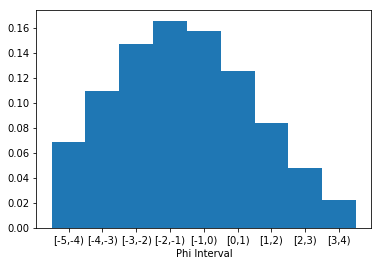

In [51]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [52]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.01562 seconds
Phi Wt perc calc time: 0.00000 seconds
Total time: 0.06250 seconds


Northing  Easting    [-5,-4)    [-4,-3)    [-3,-2)    [-2,-1)     [-1,0)  \
0      1506     1499  17.023654  24.058691  24.746126  19.010648  10.986457   
1      1997     1957  13.849036  22.187896  24.802962  20.364657  12.884741   
2      2173     1787  13.800371  22.209864  24.864958  20.379976  12.855621   
3      3082     -770  15.561092  23.674710  24.901902  19.059630  11.448421   
4      3152    -1673  16.255639  24.321103  24.942842  18.429623  10.768184   

      [0,1)     [1,2)     [2,3)     [3,4)     MassArea       radius  \
0  3.680616  0.476505  0.017266  0.000036  1316.804462  2124.861643   
1  5.062941  0.813217  0.034469  0.000080  1148.987823  2796.043276   
2  5.043105  0.811521  0.034502  0.000081  1166.987337  2813.413940   
3  4.522511  0.794749  0.036892  0.000093   300.904559  3176.731654   
4  4.367639  0.869463  0.045380  0.000126   111.014810  3568.477687   

     Residual  
0  210.419377  
1  275.404560  
2  233.099101  
3   50.613877  
4   88.698314

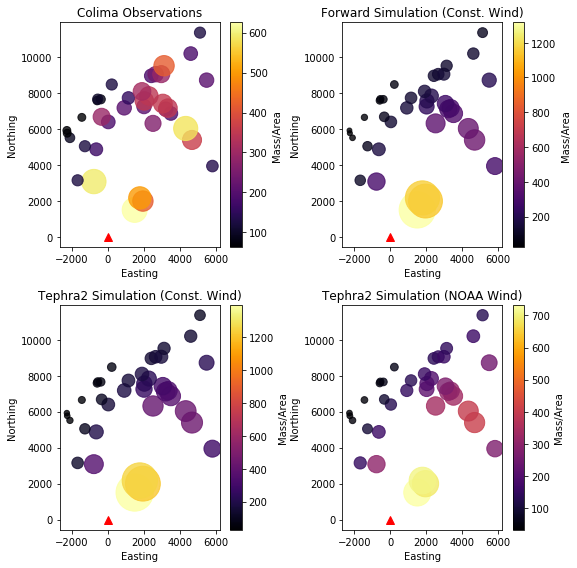

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


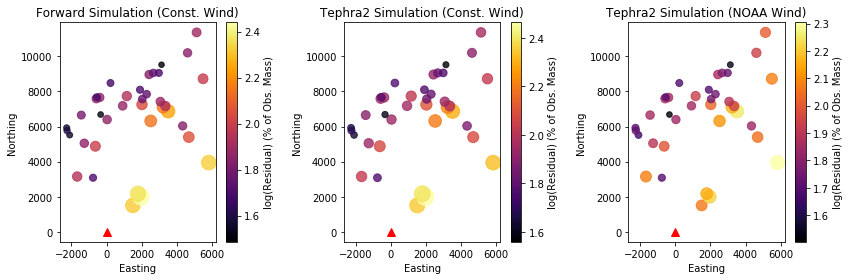

In [53]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

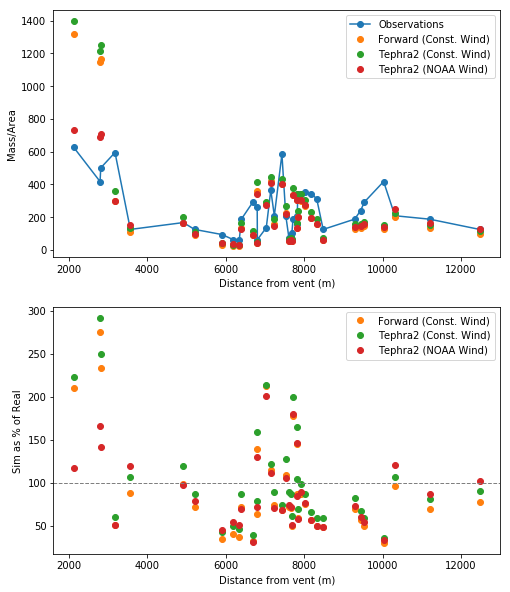

In [54]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

In [55]:
print(sum(obs_df["MassArea"].values))
print(sum(t2_df["MassArea"].values))
print(sum(forward_df["MassArea"].values))

9376.57
8279.3525
9591.480961126334


In [56]:
df = obs_df

file_tag = "obs"

err_type = "SSE"

## Leave out one

========LEFT OUT: (1499, 1506)========
a* = -3.46967	b* = 0.77585            	h1* = 2.59649
a = 1.03113	b = 3.17244	h1 = 27845.24694
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 2600.3918080805506


Height  Suspended Mass
0    4430.75    8.809397e+09
1    5776.50    7.915331e+09
2    7122.25    6.991786e+09
3    8468.00    6.097160e+09
4    9813.75    5.250891e+09
5   11159.50    4.461866e+09
6   12505.25    3.734753e+09
7   13851.00    3.072128e+09
8   15196.75    2.475359e+09
9   16542.50    1.945038e+09
10  17888.25    1.481192e+09
11  19234.00    1.083399e+09
12  20579.75    7.508316e+08
13  21925.50    4.822576e+08
14  23271.25    2.759831e+08
15  24617.00    1.297182e+08
16  25962.75    4.026837e+07
17  27308.50    2.641388e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

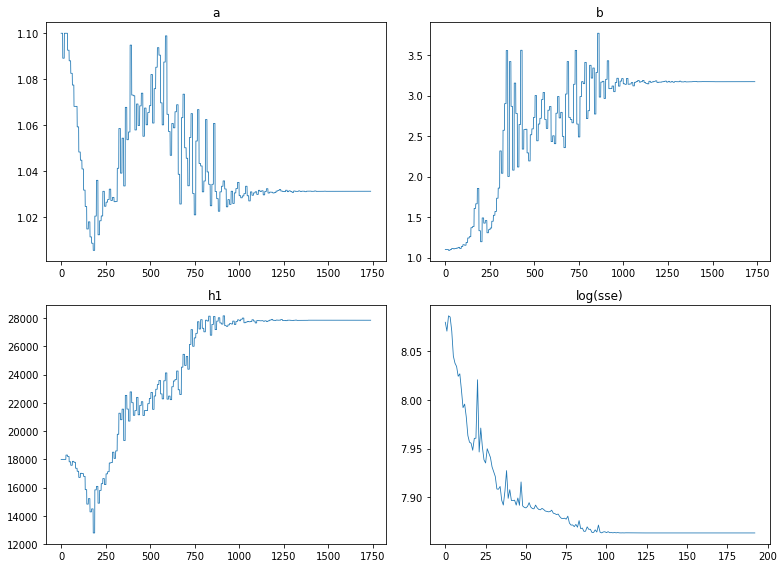

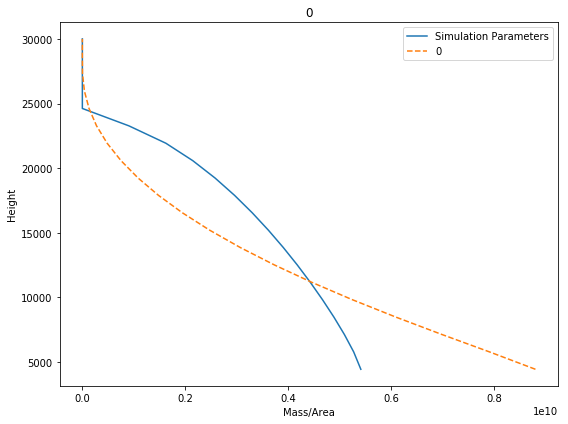

========LEFT OUT: (1957, 1997)========
a* = -3.46307	b* = 0.76933            	h1* = 2.59278
a = 1.03133	b = 3.15833	h1 = 27837.54121
Success: True, Optimization terminated successfully.
Iterations: 90
SSE: 2611.045091127231


Height  Suspended Mass
0    4430.75    8.773149e+09
1    5776.50    7.890136e+09
2    7122.25    6.975964e+09
3    8468.00    6.089153e+09
4    9813.75    5.249230e+09
5   11159.50    4.465175e+09
6   12505.25    3.741754e+09
7   13851.00    3.081641e+09
8   15196.75    2.486316e+09
9   16542.50    1.956488e+09
10  17888.25    1.492312e+09
11  19234.00    1.093505e+09
12  20579.75    7.593960e+08
13  21925.50    4.889235e+08
14  23271.25    2.805897e+08
15  24617.00    1.323343e+08
16  25962.75    4.124221e+07
17  27308.50    2.692756e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

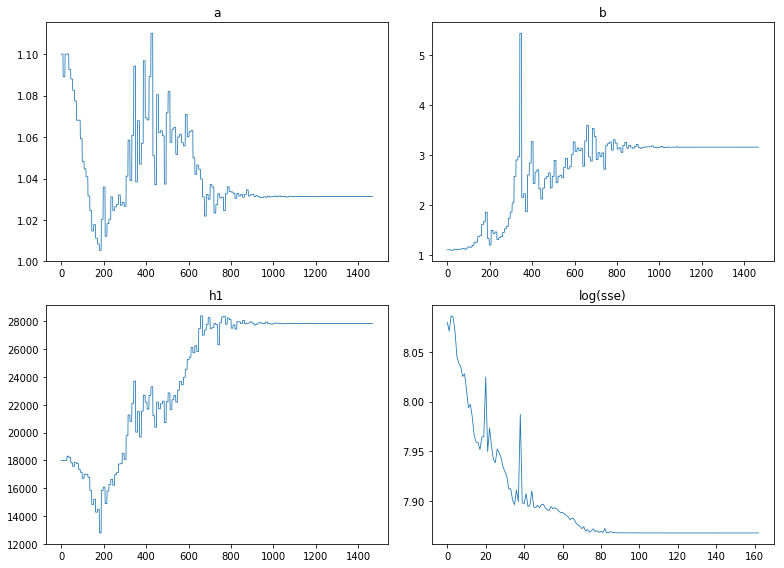

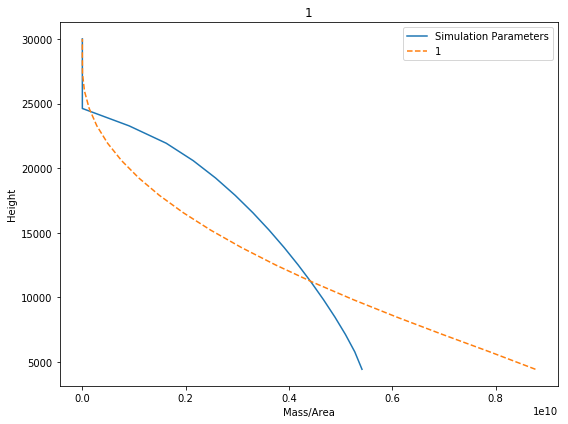

========LEFT OUT: (1787, 2173)========
a* = -3.47203	b* = 0.82759            	h1* = 2.58691
a = 1.03105	b = 3.28781	h1 = 27825.28069
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 2697.380648651853


Height  Suspended Mass
0    4430.75    9.115493e+09
1    5776.50    8.133241e+09
2    7122.25    7.131139e+09
3    8468.00    6.169623e+09
4    9813.75    5.268343e+09
5   11159.50    4.435849e+09
6   12505.25    3.676205e+09
7   13851.00    2.991218e+09
8   15196.75    2.381367e+09
9   16542.50    1.846246e+09
10  17888.25    1.384780e+09
11  19234.00    9.953313e+08
12  20579.75    6.757367e+08
13  21925.50    4.232783e+08
14  23271.25    2.345933e+08
15  24617.00    1.054767e+08
16  25962.75    3.045545e+07
17  27308.50    1.624019e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

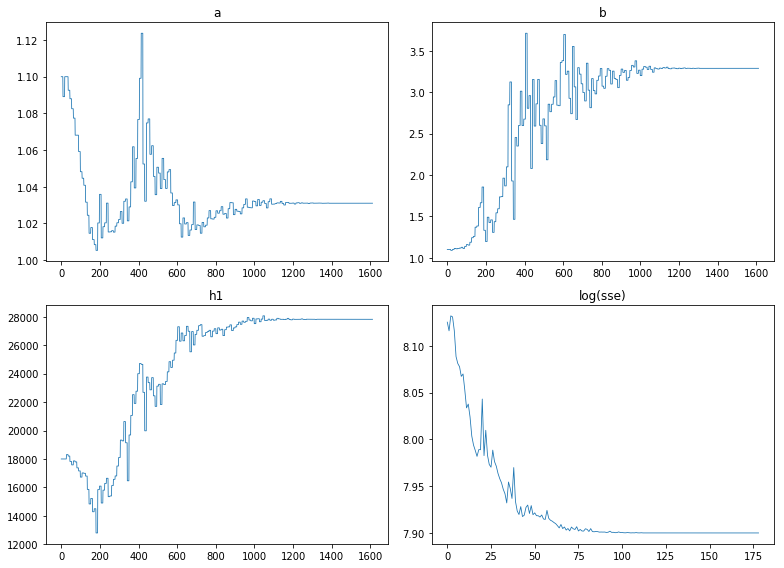

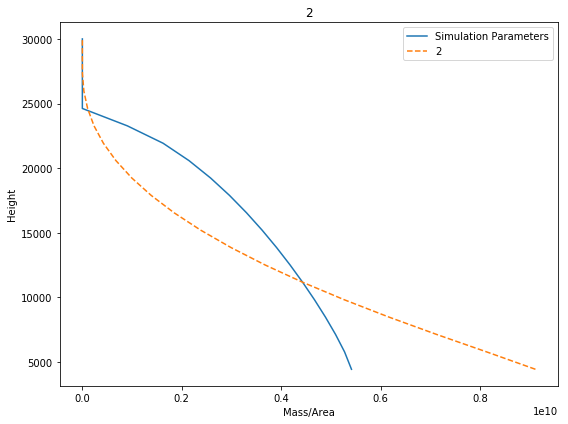

========LEFT OUT: (-770, 3082)========
a* = -3.46251	b* = 0.77427            	h1* = 2.58970
a = 1.03135	b = 3.16901	h1 = 27831.12802
Success: True, Optimization terminated successfully.
Iterations: 104
SSE: 2622.5684704907685


Height  Suspended Mass
0    4430.75    8.802901e+09
1    5776.50    7.911696e+09
2    7122.25    6.990086e+09
3    8468.00    6.096848e+09
4    9813.75    5.251560e+09
5   11159.50    4.463192e+09
6   12505.25    3.736468e+09
7   13851.00    3.074007e+09
8   15196.75    2.477220e+09
9   16542.50    1.946735e+09
10  17888.25    1.482617e+09
11  19234.00    1.084480e+09
12  20579.75    7.515363e+08
13  21925.50    4.825939e+08
14  23271.25    2.760025e+08
15  24617.00    1.295210e+08
16  25962.75    4.000825e+07
17  27308.50    2.528560e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

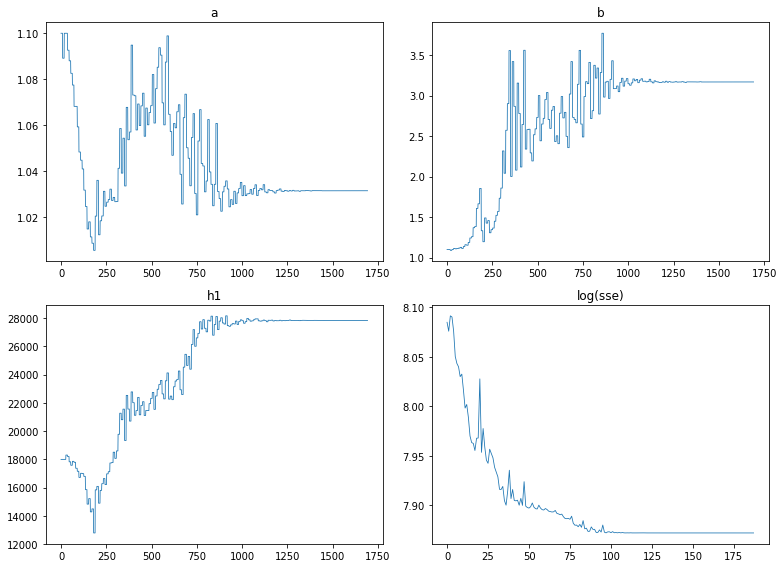

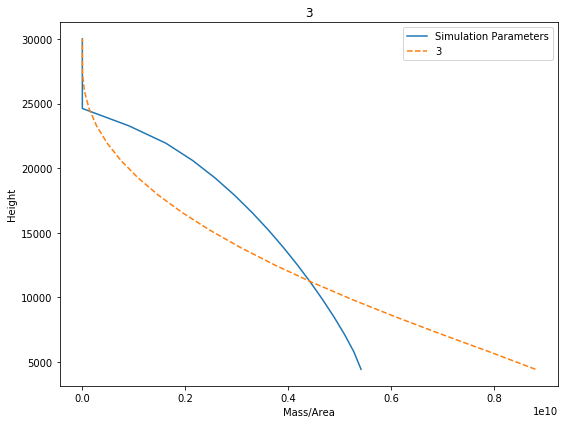

========LEFT OUT: (-1673, 3152)========
a* = -3.46077	b* = 0.76719            	h1* = 2.58911
a = 1.03141	b = 3.15371	h1 = 27829.88580
Success: True, Optimization terminated successfully.
Iterations: 91
SSE: 2621.292221764674


Height  Suspended Mass
0    4430.75    8.763033e+09
1    5776.50    7.883249e+09
2    7122.25    6.971766e+09
3    8468.00    6.087165e+09
4    9813.75    5.249012e+09
5   11159.50    4.466319e+09
6   12505.25    3.743883e+09
7   13851.00    3.084413e+09
8   15196.75    2.489424e+09
9   16542.50    1.959661e+09
10  17888.25    1.495323e+09
11  19234.00    1.096170e+09
12  20579.75    7.615779e+08
13  21925.50    4.905413e+08
14  23271.25    2.816235e+08
15  24617.00    1.328358e+08
16  25962.75    4.134949e+07
17  27308.50    2.654956e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

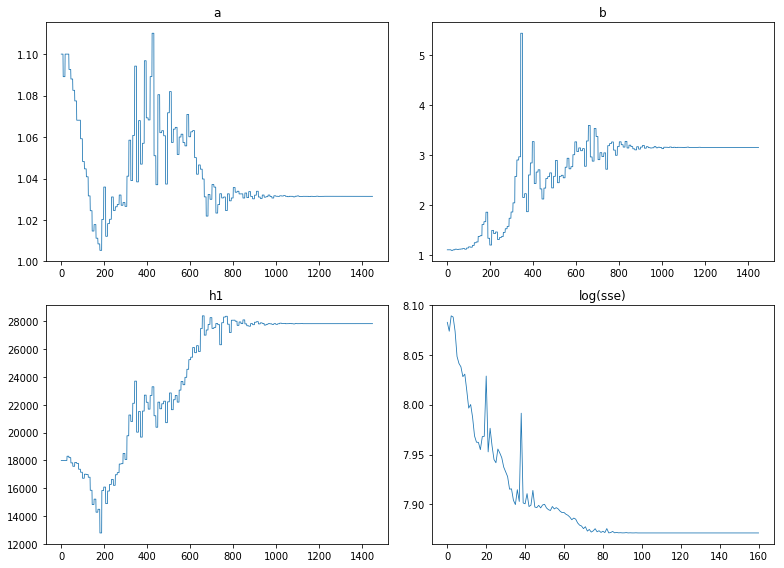

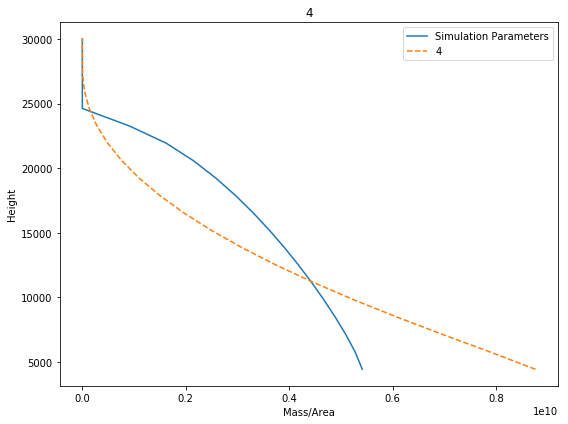

========LEFT OUT: (-637, 4876)========
a* = -3.45674	b* = 0.74840            	h1* = 2.58968
a = 1.03153	b = 3.11361	h1 = 27831.08123
Success: True, Optimization terminated successfully.
Iterations: 102
SSE: 2596.9908790878826


Height  Suspended Mass
0    4430.75    8.657048e+09
1    5776.50    7.807162e+09
2    7122.25    6.922337e+09
3    8468.00    6.060589e+09
4    9813.75    5.241413e+09
5   11159.50    4.473913e+09
6   12505.25    3.763052e+09
7   13851.00    3.111755e+09
8   15196.75    2.521793e+09
9   16542.50    1.994203e+09
10  17888.25    1.529511e+09
11  19234.00    1.127848e+09
12  20579.75    7.890062e+08
13  21925.50    5.124554e+08
14  23271.25    2.973124e+08
15  24617.00    1.422513e+08
16  25962.75    4.528072e+07
17  27308.50    3.070681e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

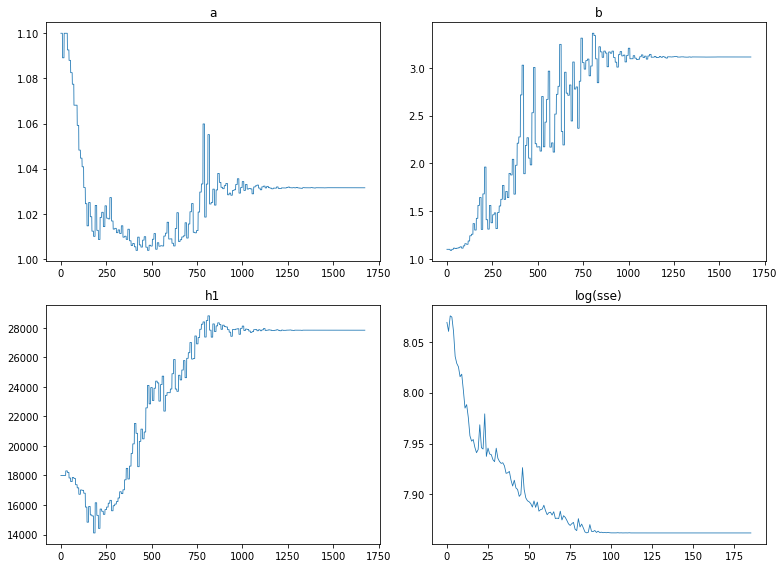

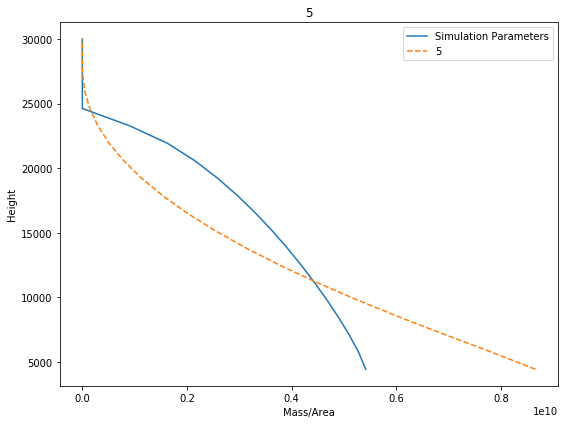

========LEFT OUT: (-1268, 5048)========
a* = -3.45783	b* = 0.75381            	h1* = 2.58859
a = 1.03150	b = 3.12509	h1 = 27828.79497
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 2599.558229128843


Height  Suspended Mass
0    4430.75    8.688065e+09
1    5776.50    7.829522e+09
2    7122.25    6.936951e+09
3    8468.00    6.068541e+09
4    9813.75    5.243814e+09
5   11159.50    4.471850e+09
6   12505.25    3.757568e+09
7   13851.00    3.103835e+09
8   15196.75    2.512350e+09
9   16542.50    1.984070e+09
10  17888.25    1.519430e+09
11  19234.00    1.118456e+09
12  20579.75    7.808245e+08
13  21925.50    5.058690e+08
14  23271.25    2.925493e+08
15  24617.00    1.393490e+08
16  25962.75    4.403337e+07
17  27308.50    2.923035e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

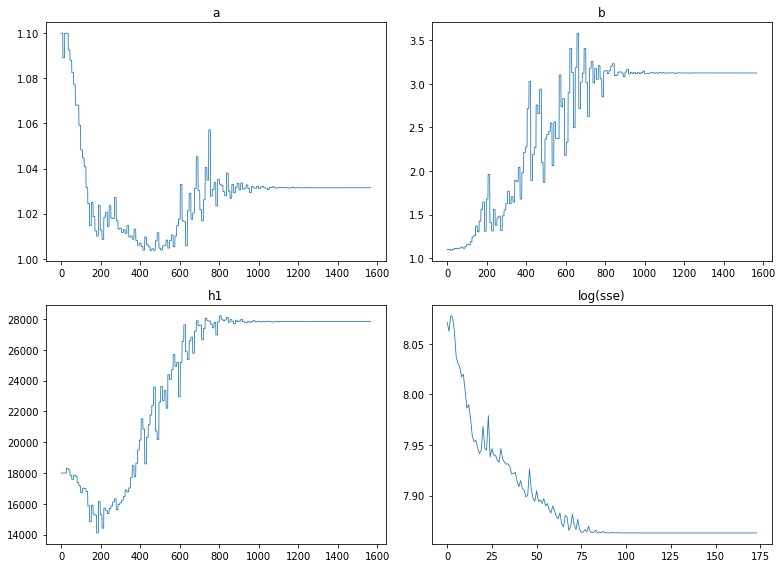

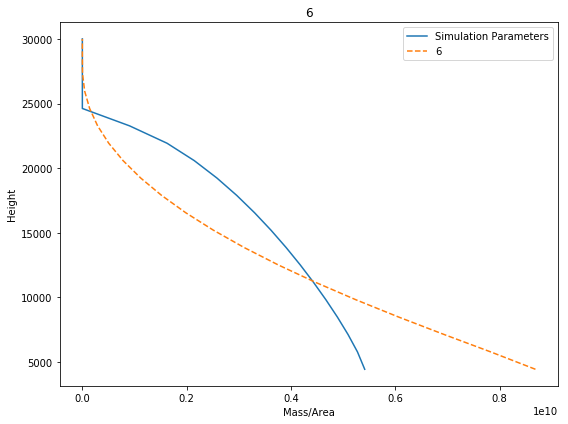

========LEFT OUT: (-2101, 5517)========
a* = -3.46111	b* = 0.76755            	h1* = 2.58990
a = 1.03139	b = 3.15449	h1 = 27831.54167
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 2620.2238279844123


Height  Suspended Mass
0    4430.75    8.764597e+09
1    5776.50    7.884306e+09
2    7122.25    6.972401e+09
3    8468.00    6.087455e+09
4    9813.75    5.249027e+09
5   11159.50    4.466125e+09
6   12505.25    3.743538e+09
7   13851.00    3.083973e+09
8   15196.75    2.488937e+09
9   16542.50    1.959170e+09
10  17888.25    1.494862e+09
11  19234.00    1.095768e+09
12  20579.75    7.612561e+08
13  21925.50    4.903101e+08
14  23271.25    2.814841e+08
15  24617.00    1.327772e+08
16  25962.75    4.134682e+07
17  27308.50    2.665231e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

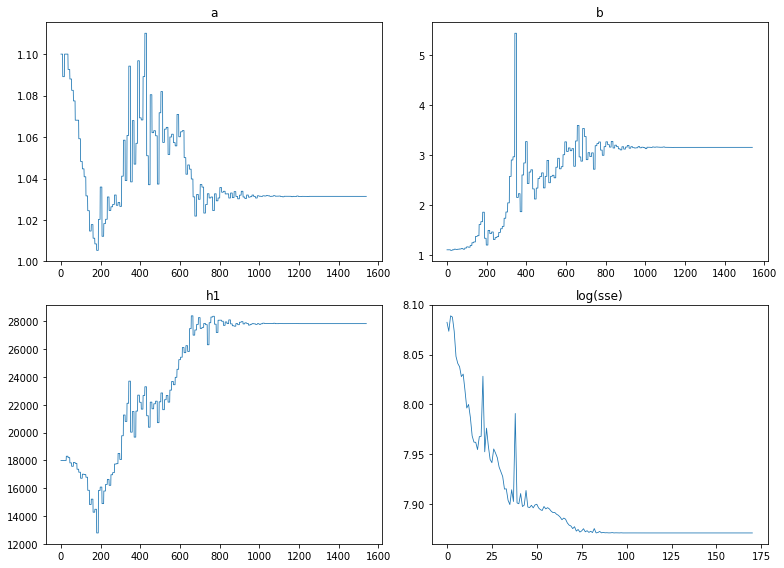

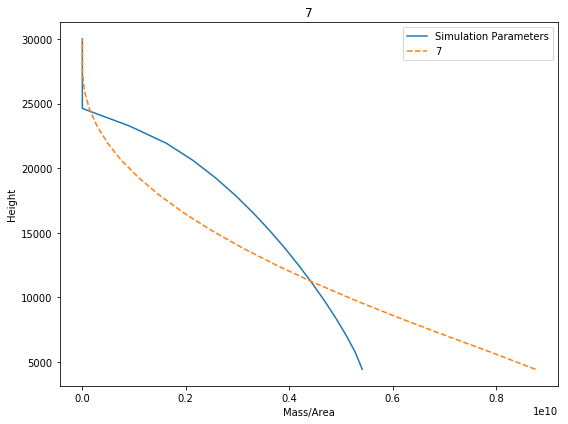

========LEFT OUT: (-2250, 5771)========
a* = -3.45859	b* = 0.75644            	h1* = 2.59092
a = 1.03147	b = 3.13067	h1 = 27833.66793
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 2606.0252735533786


Height  Suspended Mass
0    4430.75    8.701131e+09
1    5776.50    7.838788e+09
2    7122.25    6.942866e+09
3    8468.00    6.071608e+09
4    9813.75    5.244537e+09
5   11159.50    4.470718e+09
6   12505.25    3.755044e+09
7   13851.00    3.100351e+09
8   15196.75    2.508305e+09
9   16542.50    1.979820e+09
10  17888.25    1.515286e+09
11  19234.00    1.114681e+09
12  20579.75    7.776223e+08
13  21925.50    5.033808e+08
14  23271.25    2.908407e+08
15  24617.00    1.383965e+08
16  25962.75    4.370157e+07
17  27308.50    2.921905e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

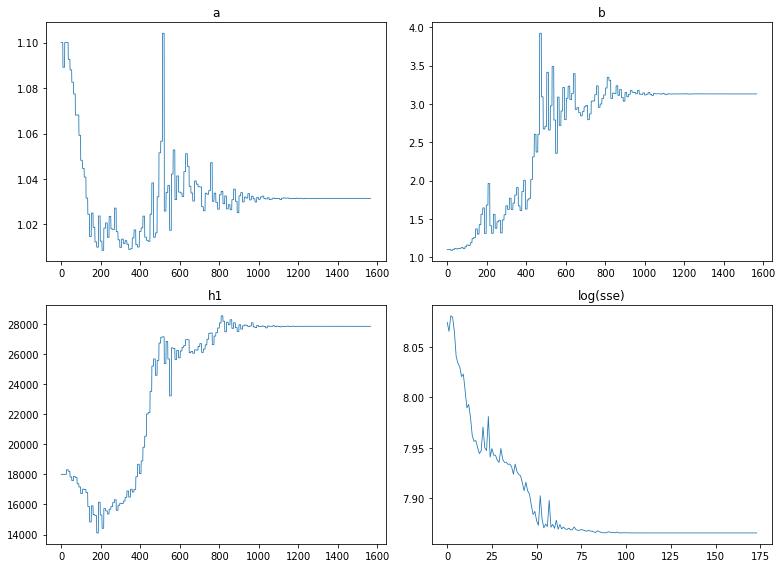

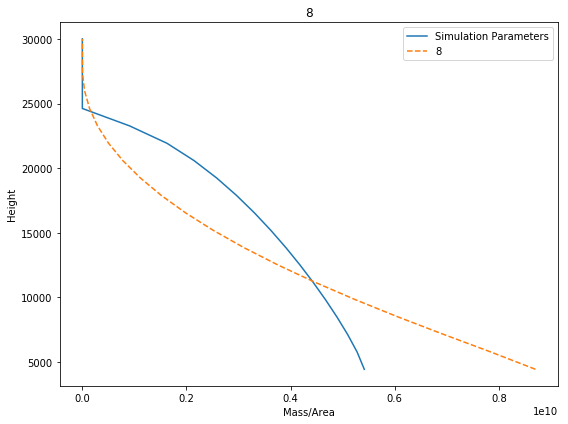

========LEFT OUT: (-2272, 5925)========
a* = -3.48212	b* = 0.86545            	h1* = 2.59025
a = 1.03074	b = 3.37607	h1 = 27832.27770
Success: True, Optimization terminated successfully.
Iterations: 116
SSE: 2744.4319613921657


Height  Suspended Mass
0    4430.75    9.343587e+09
1    5776.50    8.291842e+09
2    7122.25    7.229339e+09
3    8468.00    6.217376e+09
4    9813.75    5.275432e+09
5   11159.50    4.411554e+09
6   12505.25    3.629144e+09
7   13851.00    2.929243e+09
8   15196.75    2.311486e+09
9   16542.50    1.774553e+09
10  17888.25    1.316391e+09
11  19234.00    9.343198e+08
12  20579.75    6.250574e+08
13  21925.50    3.846884e+08
14  23271.25    2.085575e+08
15  24617.00    9.105305e+07
16  25962.75    2.515188e+07
17  27308.50    1.225607e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

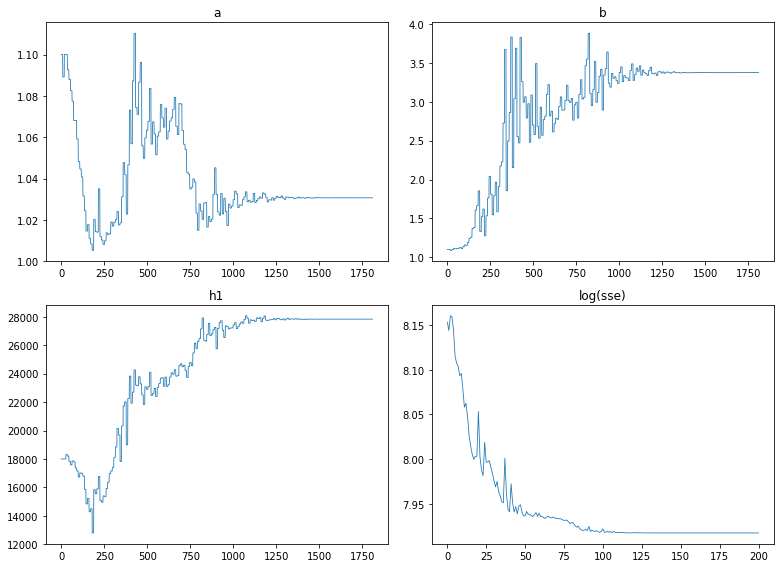

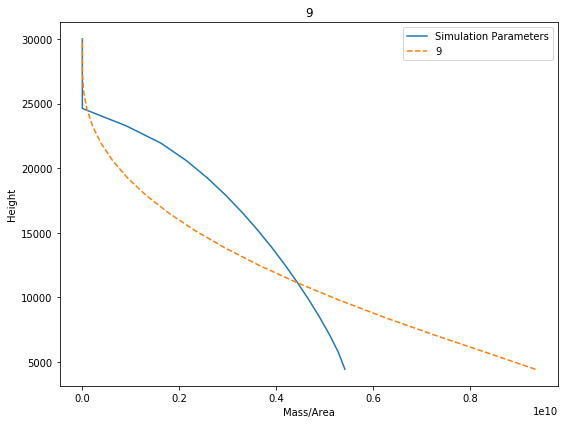

========LEFT OUT: (32, 6398)========
a* = -3.53265	b* = 1.20415            	h1* = 2.58922
a = 1.02923	b = 4.33394	h1 = 27830.11280
Success: True, Optimization terminated successfully.
Iterations: 99
SSE: 3191.2251776892263


Height  Suspended Mass
0    4430.75    1.176267e+10
1    5776.50    9.852373e+09
2    7122.25    8.082072e+09
3    8468.00    6.514507e+09
4    9813.75    5.157148e+09
5   11159.50    4.002379e+09
6   12505.25    3.036707e+09
7   13851.00    2.243970e+09
8   15196.75    1.606756e+09
9   16542.50    1.107137e+09
10  17888.25    7.271041e+08
11  19234.00    4.488597e+08
12  20579.75    2.550393e+08
13  21925.50    1.289039e+08
14  23271.25    5.452856e+07
15  24617.00    1.701829e+07
16  25962.75    2.791804e+06
17  27308.50    3.981130e+04
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

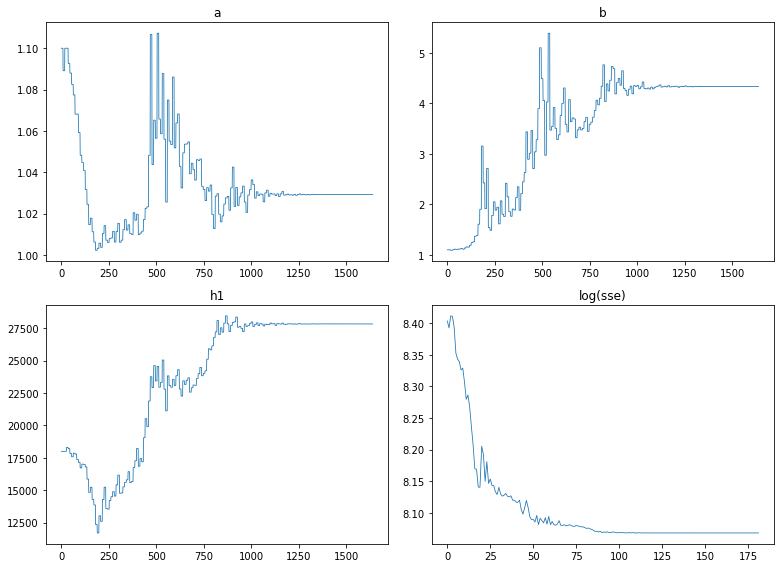

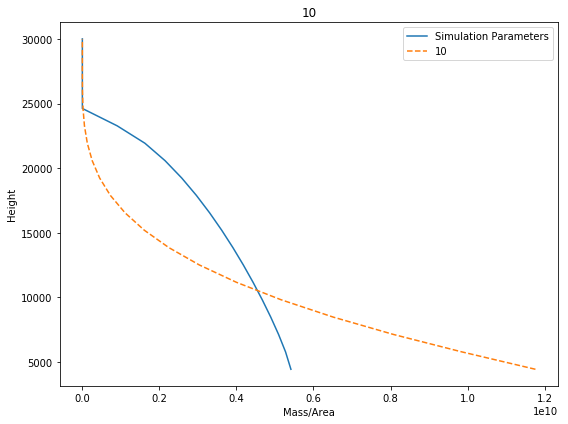

========LEFT OUT: (-337, 6683)========
a* = -3.45896	b* = 0.76864            	h1* = 2.58278
a = 1.03146	b = 3.15683	h1 = 27816.62863
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 2623.1356943517803


Height  Suspended Mass
0    4430.75    8.775138e+09
1    5776.50    7.892401e+09
2    7122.25    6.978059e+09
3    8468.00    6.090897e+09
4    9813.75    5.250535e+09
5   11159.50    4.466006e+09
6   12505.25    3.742106e+09
7   13851.00    3.081533e+09
8   15196.75    2.485788e+09
9   16542.50    1.955595e+09
10  17888.25    1.491124e+09
11  19234.00    1.092108e+09
12  20579.75    7.578877e+08
13  21925.50    4.874144e+08
14  23271.25    2.792031e+08
15  24617.00    1.312044e+08
16  25962.75    4.051051e+07
17  27308.50    2.488719e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

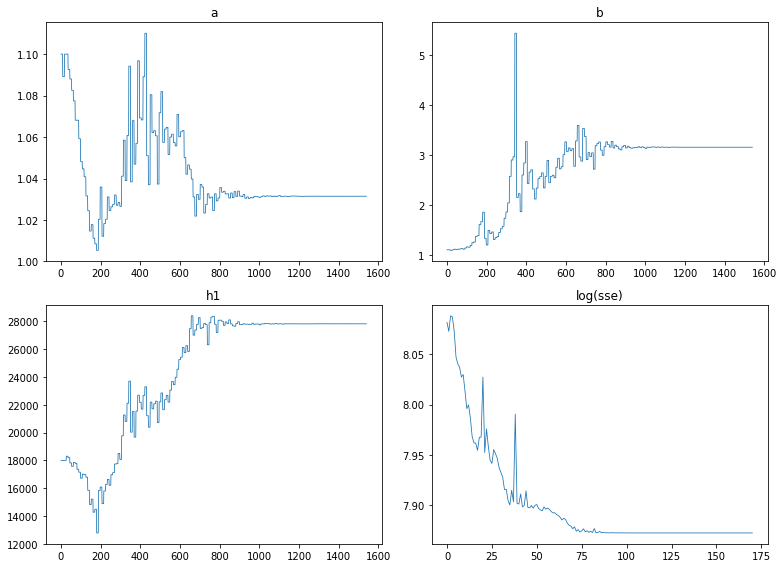

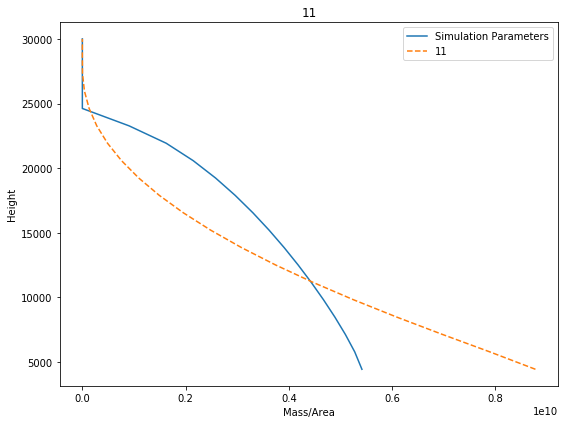

========LEFT OUT: (2519, 6318)========
a* = -3.46008	b* = 0.77046            	h1* = 2.58630
a = 1.03143	b = 3.16076	h1 = 27824.00497
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 2620.3219324435186


Height  Suspended Mass
0    4430.75    8.783120e+09
1    5776.50    7.897879e+09
2    7122.25    6.981407e+09
3    8468.00    6.092477e+09
4    9813.75    5.250695e+09
5   11159.50    4.465072e+09
6   12505.25    3.740381e+09
7   13851.00    3.079297e+09
8   15196.75    2.483289e+09
9   16542.50    1.953052e+09
10  17888.25    1.488724e+09
11  19234.00    1.089998e+09
12  20579.75    7.561764e+08
13  21925.50    4.861647e+08
14  23271.25    2.784261e+08
15  24617.00    1.308515e+08
16  25962.75    4.046068e+07
17  27308.50    2.529500e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

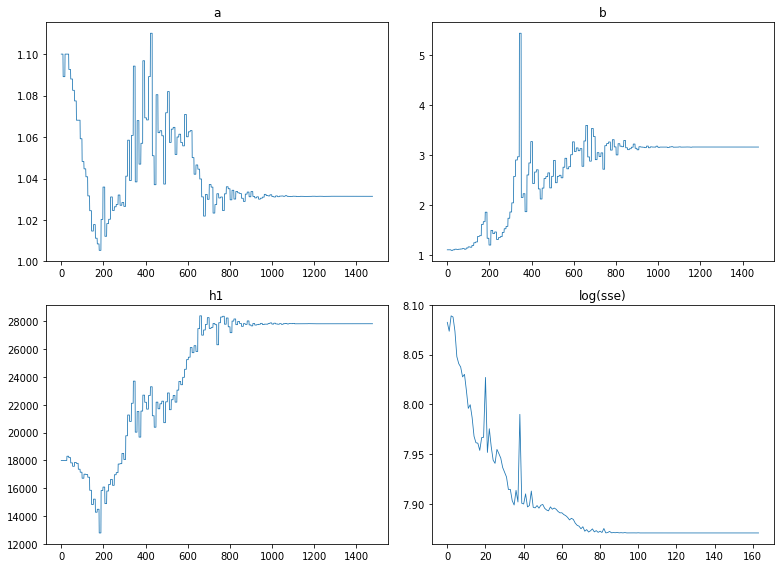

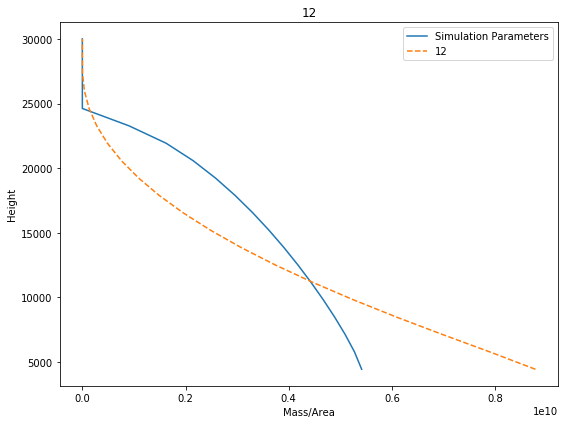

========LEFT OUT: (-1439, 6652)========
a* = -3.45972	b* = 0.75910            	h1* = 2.59029
a = 1.03144	b = 3.13636	h1 = 27832.34311
Success: True, Optimization terminated successfully.
Iterations: 102
SSE: 2610.293971348228


Height  Suspended Mass
0    4430.75    8.716768e+09
1    5776.50    7.849979e+09
2    7122.25    6.950132e+09
3    8468.00    6.075520e+09
4    9813.75    5.245668e+09
5   11159.50    4.469623e+09
6   12505.25    3.752251e+09
7   13851.00    3.096357e+09
8   15196.75    2.503567e+09
9   16542.50    1.974755e+09
10  17888.25    1.510263e+09
11  19234.00    1.110015e+09
12  20579.75    7.735684e+08
13  21925.50    5.001267e+08
14  23271.25    2.884946e+08
15  24617.00    1.369716e+08
16  25962.75    4.309112e+07
17  27308.50    2.849256e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

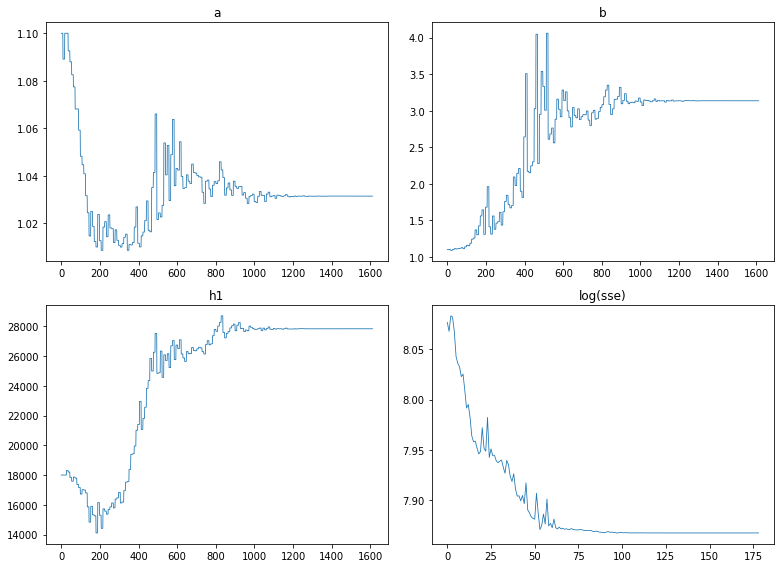

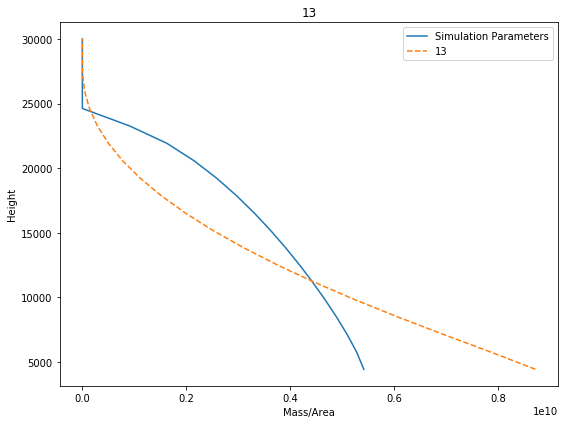

========LEFT OUT: (5823, 3944)========
a* = -3.45808	b* = 0.75479            	h1* = 2.58940
a = 1.03149	b = 3.12716	h1 = 27830.48838
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 2605.8817827983903


Height  Suspended Mass
0    4430.75    8.692933e+09
1    5776.50    7.832981e+09
2    7122.25    6.939165e+09
3    8468.00    6.069694e+09
4    9813.75    5.244093e+09
5   11159.50    4.471436e+09
6   12505.25    3.756633e+09
7   13851.00    3.102539e+09
8   15196.75    2.510842e+09
9   16542.50    1.982484e+09
10  17888.25    1.517881e+09
11  19234.00    1.117043e+09
12  20579.75    7.796232e+08
13  21925.50    5.049332e+08
14  23271.25    2.919044e+08
15  24617.00    1.389871e+08
16  25962.75    4.390519e+07
17  27308.50    2.921358e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

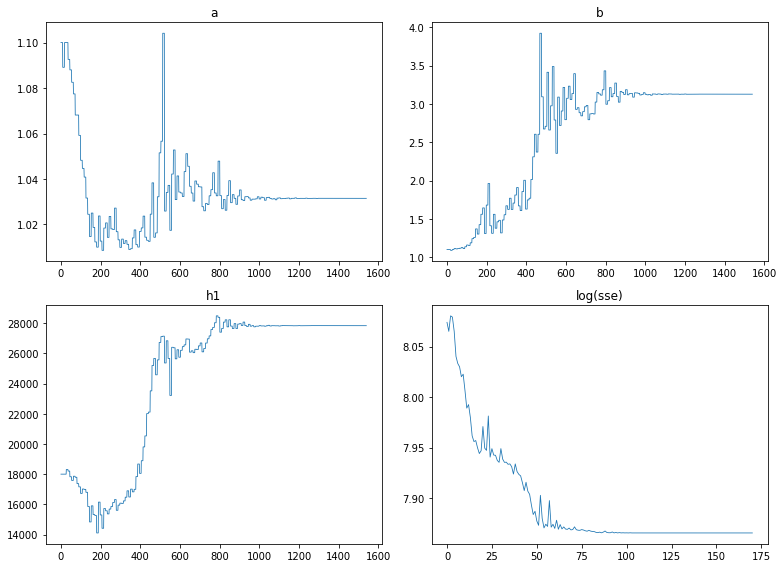

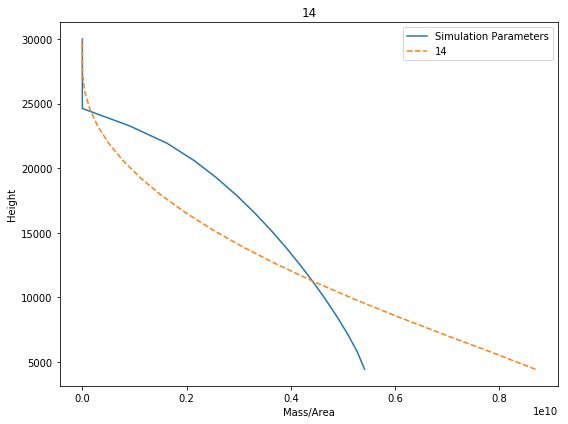

========LEFT OUT: (4688, 5396)========
a* = -3.46431	b* = 0.77540            	h1* = 2.59281
a = 1.03129	b = 3.17146	h1 = 27837.61442
Success: True, Optimization terminated successfully.
Iterations: 103
SSE: 2620.3268586327945


Height  Suspended Mass
0    4430.75    8.807609e+09
1    5776.50    7.914761e+09
2    7122.25    6.991847e+09
3    8468.00    6.097570e+09
4    9813.75    5.251475e+09
5   11159.50    4.462507e+09
6   12505.25    3.735369e+09
7   13851.00    3.072661e+09
8   15196.75    2.475771e+09
9   16542.50    1.945307e+09
10  17888.25    1.481311e+09
11  19234.00    1.083373e+09
12  20579.75    7.506814e+08
13  21925.50    4.820138e+08
14  23271.25    2.756890e+08
15  24617.00    1.294297e+08
16  25962.75    4.005272e+07
17  27308.50    2.572550e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

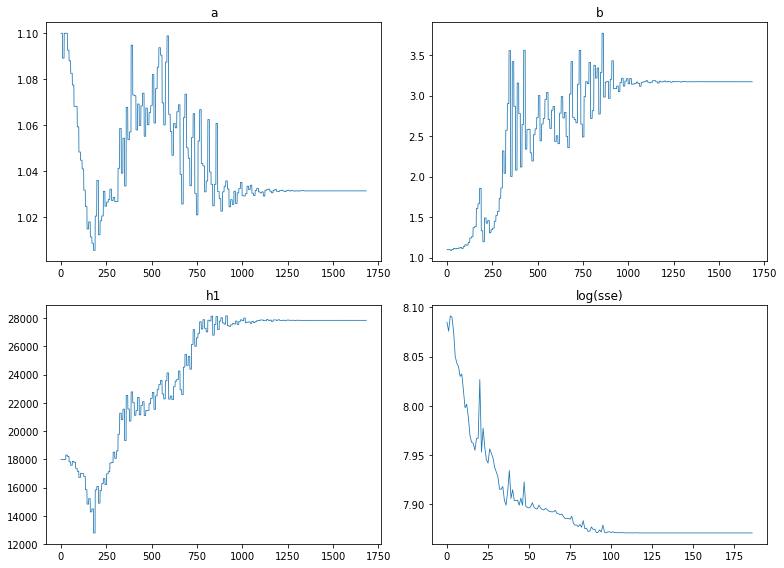

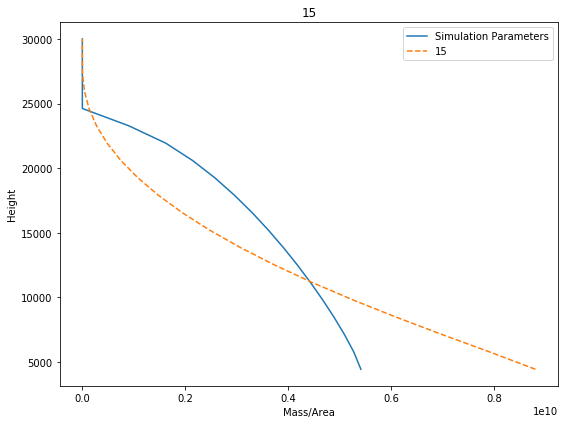

========LEFT OUT: (918, 7180)========
a* = -3.48636	b* = 0.87209            	h1* = 2.62301
a = 1.03061	b = 3.39191	h1 = 27899.61901
Success: True, Optimization terminated successfully.
Iterations: 108
SSE: 2176.968021872984


Height  Suspended Mass
0    4430.75    9.360678e+09
1    5776.50    8.301949e+09
2    7122.25    7.233979e+09
3    8468.00    6.217868e+09
4    9813.75    5.272945e+09
5   11159.50    4.407120e+09
6   12505.25    3.623655e+09
7   13851.00    2.923451e+09
8   15196.75    2.306000e+09
9   16542.50    1.769835e+09
10  17888.25    1.312755e+09
11  19234.00    9.319286e+08
12  20579.75    6.239199e+08
13  21925.50    3.846603e+08
14  23271.25    2.093445e+08
15  24617.00    9.222081e+07
16  25962.75    2.615776e+07
17  27308.50    1.532888e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

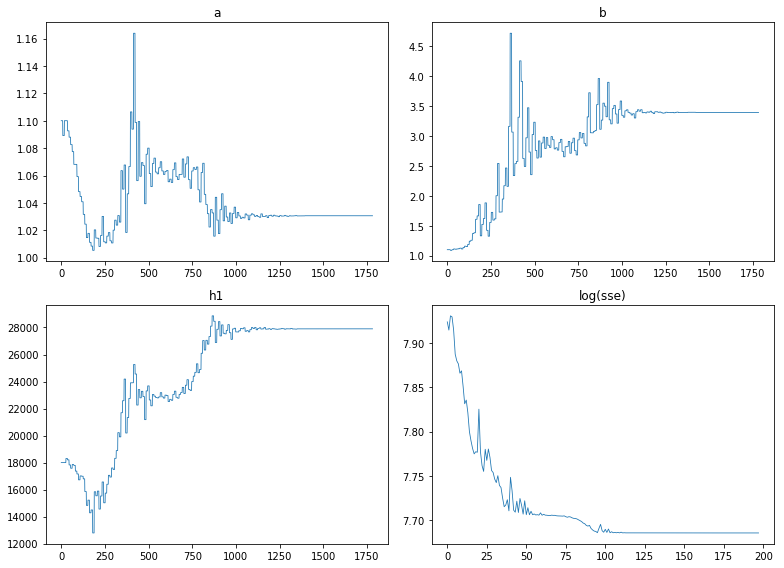

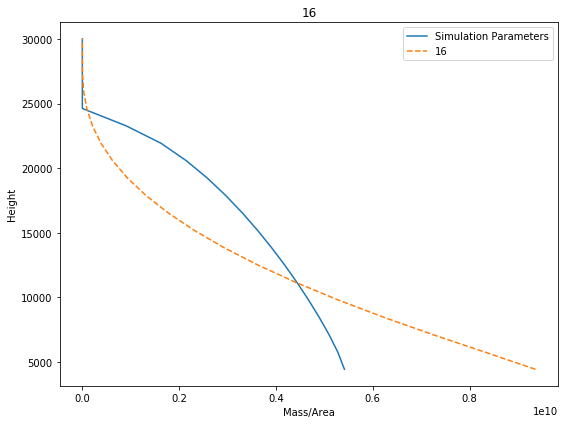

========LEFT OUT: (4337, 6035)========
a* = -3.45645	b* = 0.75737            	h1* = 2.57626
a = 1.03154	b = 3.13266	h1 = 27802.87910
Success: True, Optimization terminated successfully.
Iterations: 106
SSE: 2325.763671619823


Height  Suspended Mass
0    4430.75    8.716282e+09
1    5776.50    7.850533e+09
2    7122.25    6.951243e+09
3    8468.00    6.076899e+09
4    9813.75    5.247103e+09
5   11159.50    4.470953e+09
6   12505.25    3.753352e+09
7   13851.00    3.097136e+09
8   15196.75    2.503963e+09
9   16542.50    1.974739e+09
10  17888.25    1.509834e+09
11  19234.00    1.109205e+09
12  20579.75    7.724452e+08
13  21925.50    4.987936e+08
14  23271.25    2.870952e+08
15  24617.00    1.356937e+08
16  25962.75    4.217007e+07
17  27308.50    2.561474e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

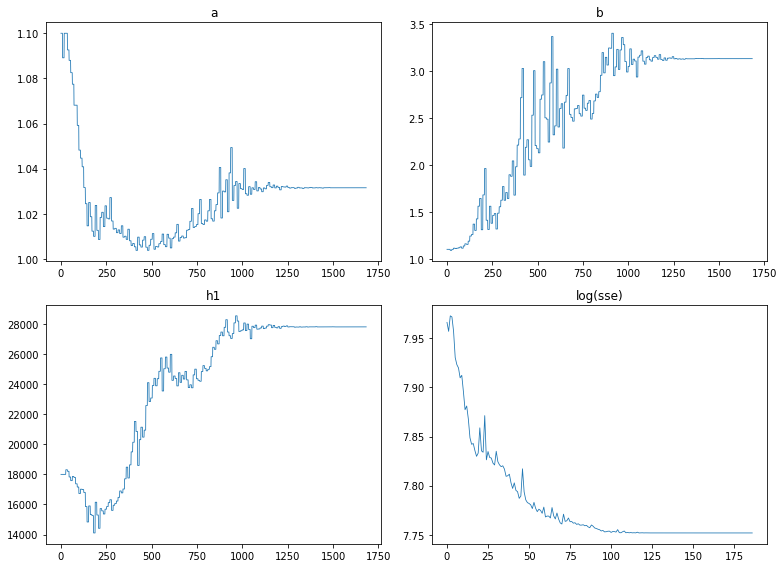

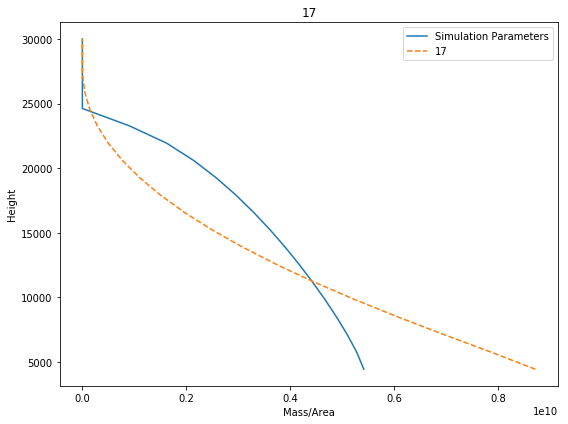

========LEFT OUT: (2019, 7255)========
a* = -3.46808	b* = 0.78491            	h1* = 2.57446
a = 1.03118	b = 3.19221	h1 = 27799.06724
Success: True, Optimization terminated successfully.
Iterations: 110
SSE: 2328.157507490332


Height  Suspended Mass
0    4430.75    8.876407e+09
1    5776.50    7.964382e+09
2    7122.25    7.024411e+09
3    8468.00    6.115493e+09
4    9813.75    5.257192e+09
5   11159.50    4.458391e+09
6   12505.25    3.723687e+09
7   13851.00    3.055544e+09
8   15196.75    2.455198e+09
9   16542.50    1.923080e+09
10  17888.25    1.459036e+09
11  19234.00    1.062441e+09
12  20579.75    7.322349e+08
13  21925.50    4.669221e+08
14  23271.25    2.645026e+08
15  24617.00    1.223212e+08
16  25962.75    3.672033e+07
17  27308.50    2.037028e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

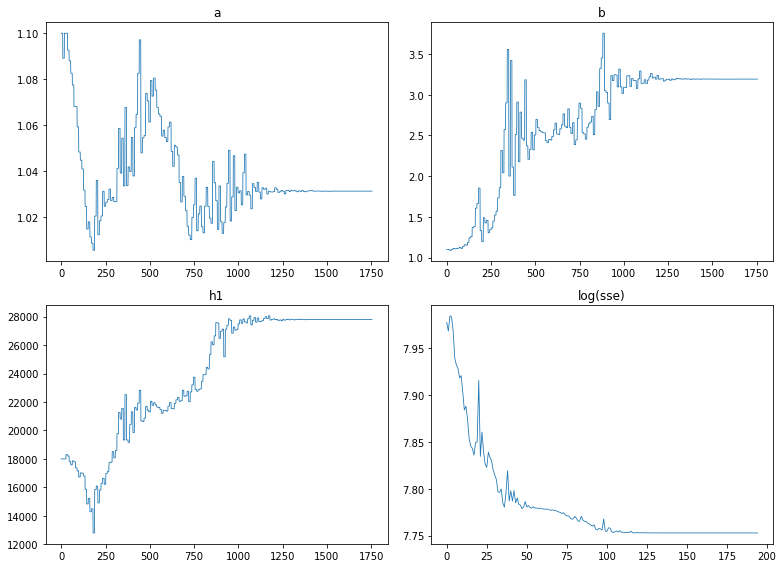

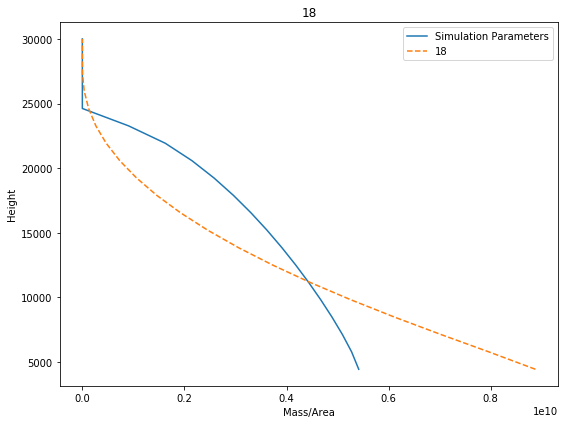

========LEFT OUT: (-586, 7588)========
a* = -3.46286	b* = 0.76995            	h1* = 2.59290
a = 1.03134	b = 3.15965	h1 = 27837.80279
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 2614.8650208098443


Height  Suspended Mass
0    4430.75    8.776406e+09
1    5776.50    7.892495e+09
2    7122.25    6.977499e+09
3    8468.00    6.089975e+09
4    9813.75    5.249459e+09
5   11159.50    4.464929e+09
6   12505.25    3.741147e+09
7   13851.00    3.080781e+09
8   15196.75    2.485303e+09
9   16542.50    1.955411e+09
10  17888.25    1.491252e+09
11  19234.00    1.092529e+09
12  20579.75    7.585574e+08
13  21925.50    4.882602e+08
14  23271.25    2.801215e+08
15  24617.00    1.320594e+08
16  25962.75    4.113236e+07
17  27308.50    2.683158e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

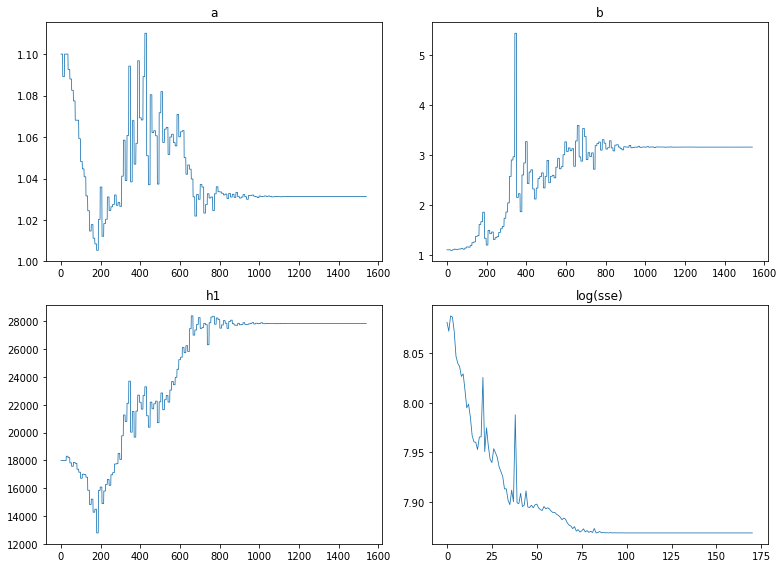

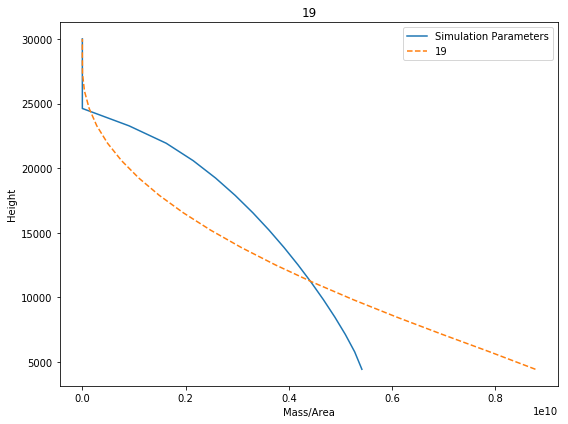

========LEFT OUT: (-387, 7656)========
a* = -3.46035	b* = 0.76582            	h1* = 2.58499
a = 1.03142	b = 3.15075	h1 = 27821.27134
Success: True, Optimization terminated successfully.
Iterations: 95
SSE: 2616.8683146816884


Height  Suspended Mass
0    4430.75    8.758232e+09
1    5776.50    7.880001e+09
2    7122.25    6.969848e+09
3    8468.00    6.086345e+09
4    9813.75    5.249064e+09
5   11159.50    4.467029e+09
6   12505.25    3.745053e+09
7   13851.00    3.085862e+09
8   15196.75    2.490991e+09
9   16542.50    1.961208e+09
10  17888.25    1.496735e+09
11  19234.00    1.097358e+09
12  20579.75    7.624828e+08
13  21925.50    4.911366e+08
14  23271.25    2.819198e+08
15  24617.00    1.328864e+08
16  25962.75    4.125931e+07
17  27308.50    2.591235e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

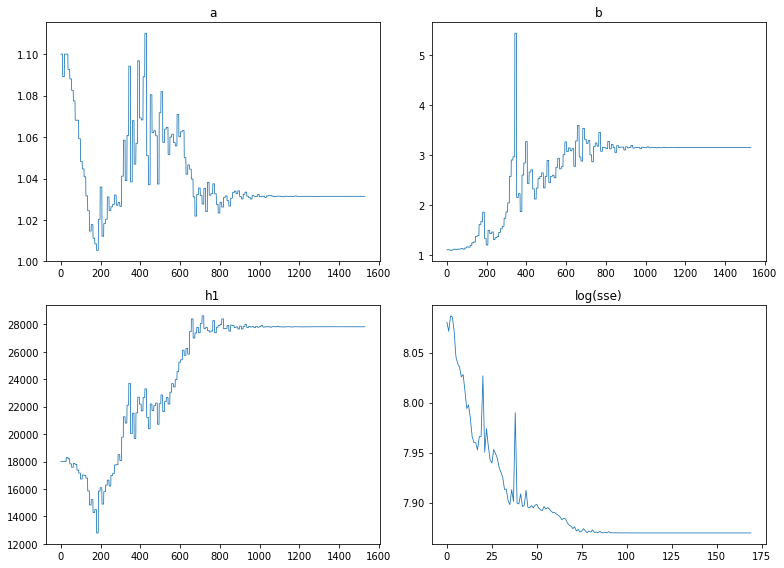

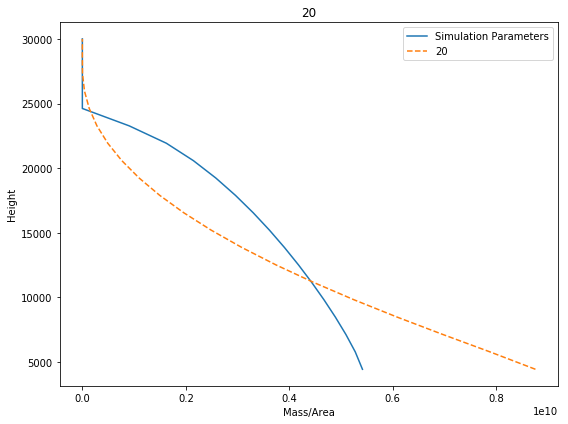

========LEFT OUT: (-555, 7666)========
a* = -3.45903	b* = 0.78076            	h1* = 2.58231
a = 1.03146	b = 3.18313	h1 = 27815.62946
Success: True, Optimization terminated successfully.
Iterations: 111
SSE: 2622.9389298650403


Height  Suspended Mass
0    4430.75    8.843703e+09
1    5776.50    7.941623e+09
2    7122.25    7.009904e+09
3    8468.00    6.107834e+09
4    9813.75    5.255117e+09
5   11159.50    4.460734e+09
6   12505.25    3.729373e+09
7   13851.00    3.063584e+09
8   15196.75    2.464691e+09
9   16542.50    1.933216e+09
10  17888.25    1.469103e+09
11  19234.00    1.071829e+09
12  20579.75    7.404506e+08
13  21925.50    4.735980e+08
14  23271.25    2.694153e+08
15  24617.00    1.254161e+08
16  25962.75    3.815262e+07
17  27308.50    2.258372e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

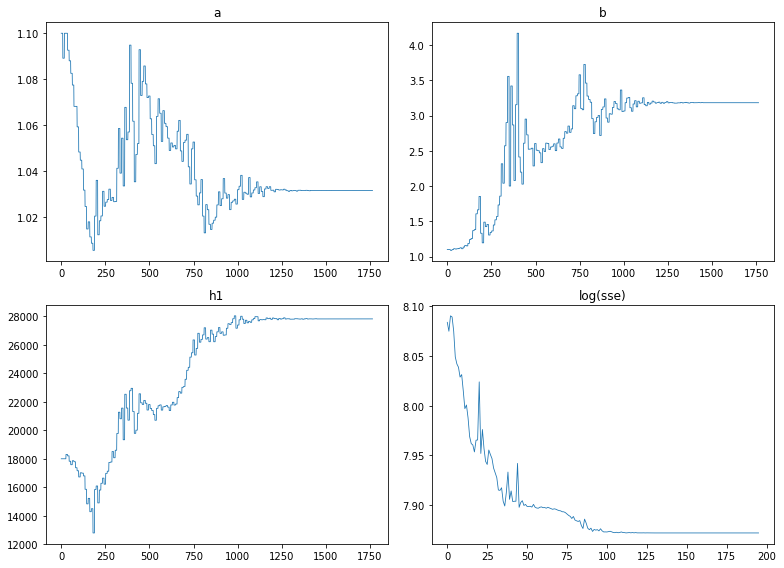

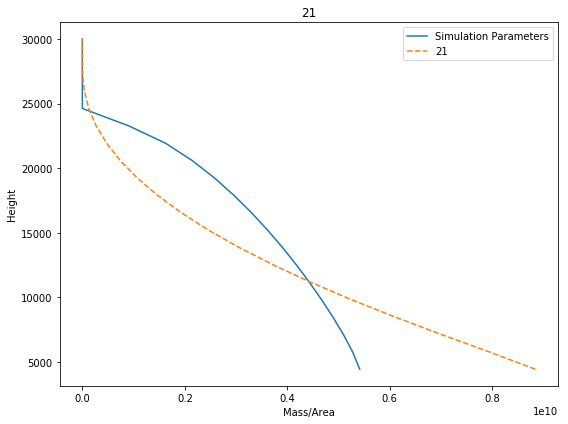

========LEFT OUT: (3512, 6869)========
a* = -3.46399	b* = 0.78986            	h1* = 2.59093
a = 1.03130	b = 3.20309	h1 = 27833.69118
Success: True, Optimization terminated successfully.
Iterations: 112
SSE: 2607.905639868126


Height  Suspended Mass
0    4430.75    8.890779e+09
1    5776.50    7.974425e+09
2    7122.25    7.030392e+09
3    8468.00    6.118013e+09
4    9813.75    5.256930e+09
5   11159.50    4.456026e+09
6   12505.25    3.719868e+09
7   13851.00    3.050869e+09
8   15196.75    2.450200e+09
9   16542.50    1.918218e+09
10  17888.25    1.454684e+09
11  19234.00    1.058877e+09
12  20579.75    7.296353e+08
13  21925.50    4.653447e+08
14  23271.25    2.638758e+08
15  24617.00    1.224261e+08
16  25962.75    3.717080e+07
17  27308.50    2.266931e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

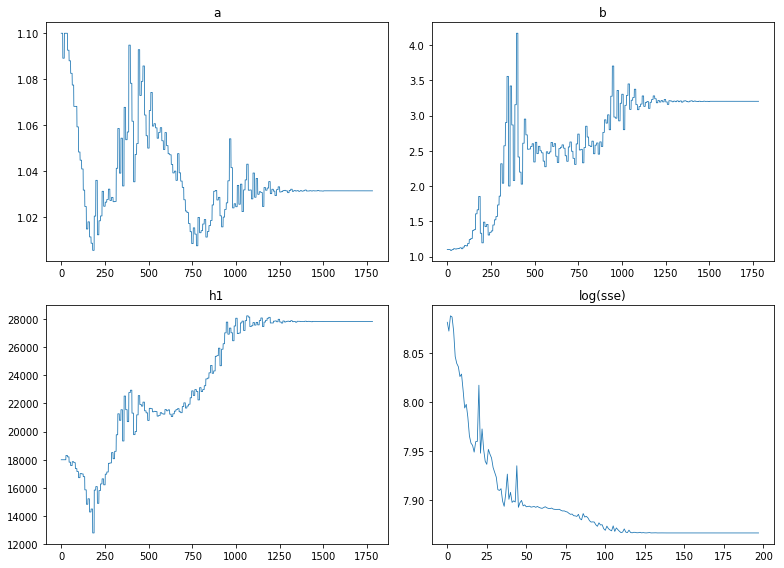

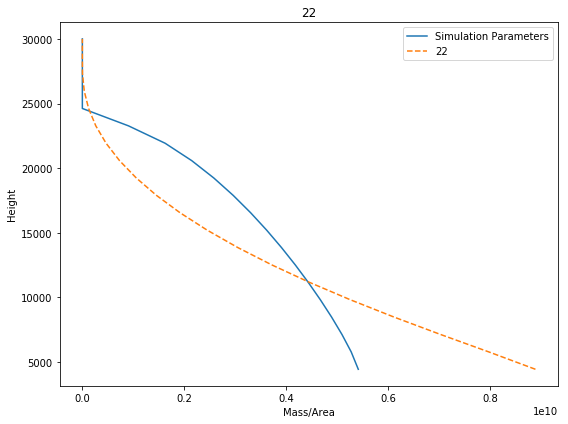

========LEFT OUT: (3226, 7110)========
a* = -3.44211	b* = 0.69820            	h1* = 2.58265
a = 1.03200	b = 3.01013	h1 = 27816.35408
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 2530.838045272478


Height  Suspended Mass
0    4430.75    8.387156e+09
1    5776.50    7.612133e+09
2    7122.25    6.794219e+09
3    8468.00    5.990130e+09
4    9813.75    5.219184e+09
5   11159.50    4.490656e+09
6   12505.25    3.809854e+09
7   13851.00    3.180169e+09
8   15196.75    2.603927e+09
9   16542.50    2.082813e+09
10  17888.25    1.618093e+09
11  19234.00    1.210743e+09
12  20579.75    8.615311e+08
13  21925.50    5.710613e+08
14  23271.25    3.398066e+08
15  24617.00    1.681207e+08
16  25962.75    5.623055e+07
17  27308.50    4.173649e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

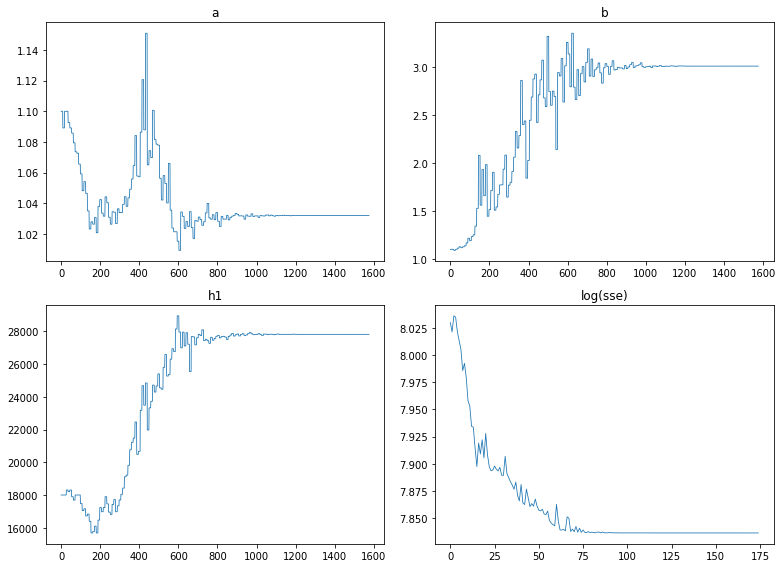

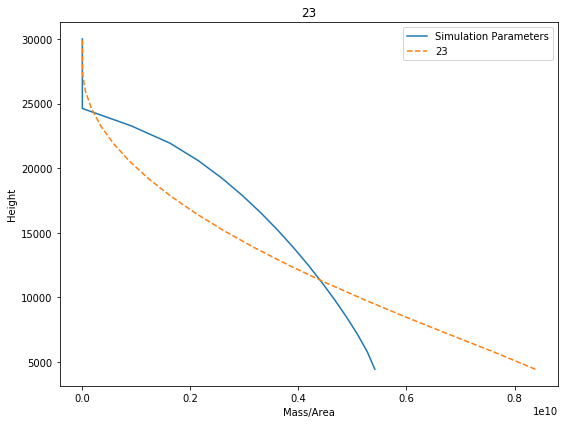

========LEFT OUT: (1154, 7735)========
a* = -3.45603	b* = 0.75400            	h1* = 2.58048
a = 1.03155	b = 3.12547	h1 = 27811.77610
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 2597.4682209755338


Height  Suspended Mass
0    4430.75    8.694343e+09
1    5776.50    7.834571e+09
2    7122.25    6.940678e+09
3    8468.00    6.071006e+09
4    9813.75    5.245133e+09
5   11159.50    4.472162e+09
6   12505.25    3.757025e+09
7   13851.00    3.102595e+09
8   15196.75    2.510573e+09
9   16542.50    1.981915e+09
10  17888.25    1.517055e+09
11  19234.00    1.116014e+09
12  20579.75    7.784622e+08
13  21925.50    5.037262e+08
14  23271.25    2.907540e+08
15  24617.00    1.380140e+08
16  25962.75    4.324731e+07
17  27308.50    2.726205e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

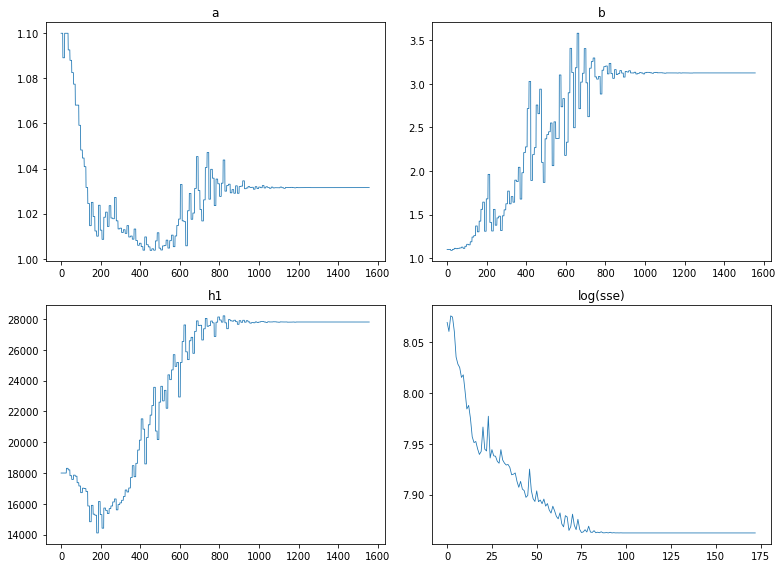

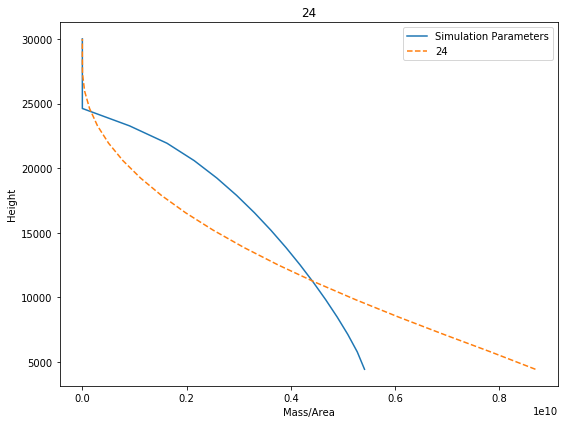

========LEFT OUT: (2037, 7565)========
a* = -3.46134	b* = 0.77746            	h1* = 2.59343
a = 1.03139	b = 3.17594	h1 = 27838.90156
Success: True, Optimization terminated successfully.
Iterations: 95
SSE: 2622.5456250452717


Height  Suspended Mass
0    4430.75    8.817679e+09
1    5776.50    7.922278e+09
2    7122.25    6.996836e+09
3    8468.00    6.100306e+09
4    9813.75    5.252303e+09
5   11159.50    4.461792e+09
6   12505.25    3.733472e+09
7   13851.00    3.069929e+09
8   15196.75    2.472529e+09
9   16542.50    1.941850e+09
10  17888.25    1.477902e+09
11  19234.00    1.080233e+09
12  20579.75    7.479864e+08
13  21925.50    4.798878e+08
14  23271.25    2.741957e+08
15  24617.00    1.285612e+08
16  25962.75    3.971268e+07
17  27308.50    2.545953e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

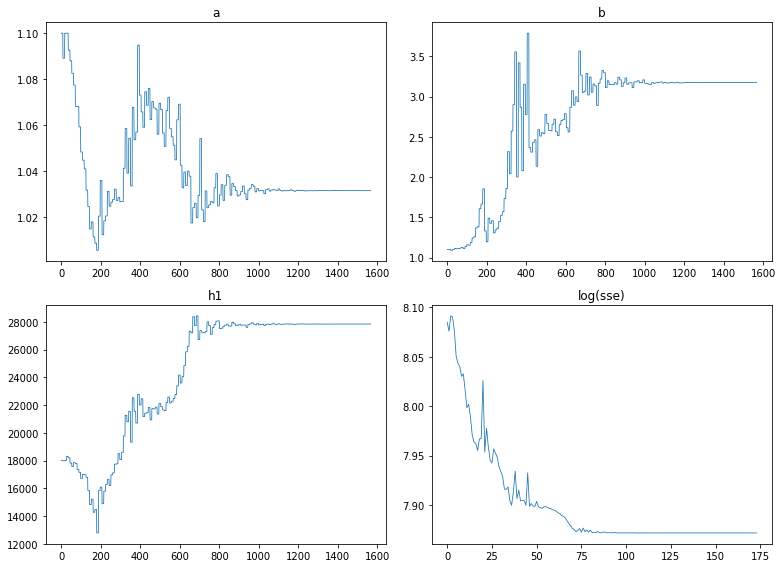

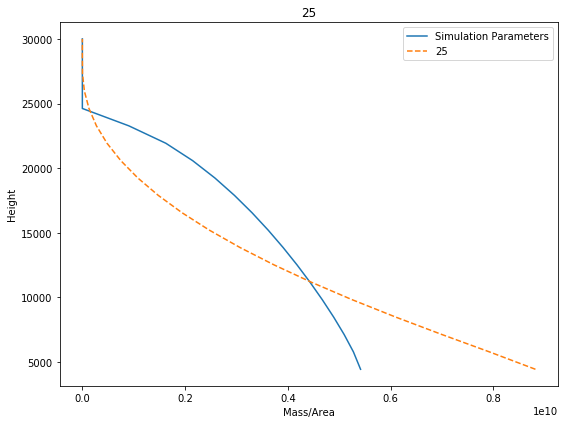

========LEFT OUT: (3352, 7167)========
a* = -3.46065	b* = 0.77865            	h1* = 2.58657
a = 1.03141	b = 3.17853	h1 = 27824.58259
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 2622.6552373047048


Height  Suspended Mass
0    4430.75    8.829187e+09
1    5776.50    7.930877e+09
2    7122.25    7.002709e+09
3    8468.00    6.103766e+09
4    9813.75    5.253697e+09
5   11159.50    4.461474e+09
6   12505.25    3.731794e+09
7   13851.00    3.067228e+09
8   15196.75    2.469127e+09
9   16542.50    1.938048e+09
10  17888.25    1.473976e+09
11  19234.00    1.076433e+09
12  20579.75    7.445267e+08
13  21925.50    4.769480e+08
14  23271.25    2.719104e+08
15  24617.00    1.270107e+08
16  25962.75    3.890615e+07
17  27308.50    2.381643e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

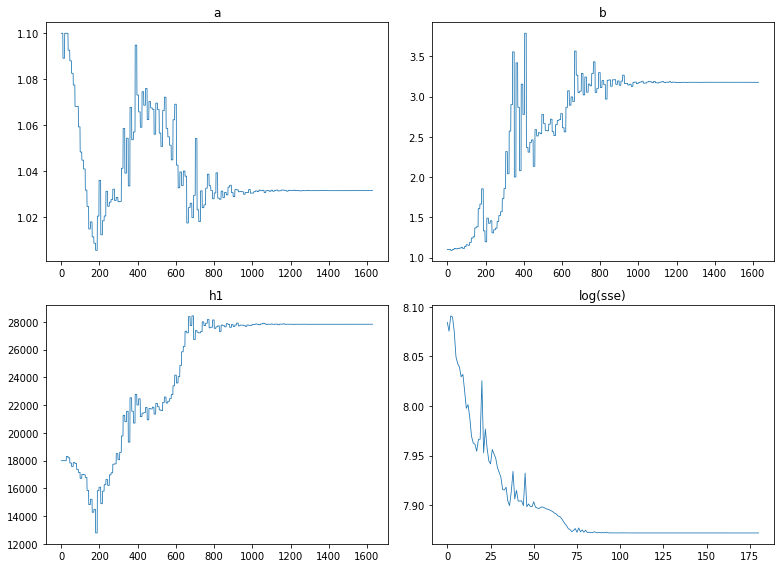

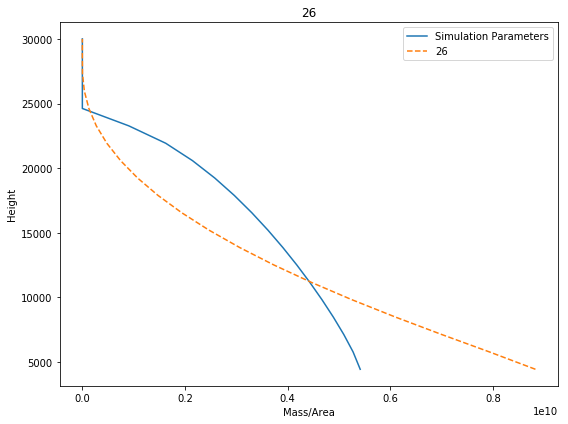

========LEFT OUT: (3066, 7419)========
a* = -3.46262	b* = 0.77402            	h1* = 2.59095
a = 1.03135	b = 3.16846	h1 = 27833.72073
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 2612.464782482274


Height  Suspended Mass
0    4430.75    8.800603e+09
1    5776.50    7.909985e+09
2    7122.25    6.988922e+09
3    8468.00    6.096167e+09
4    9813.75    5.251291e+09
5   11159.50    4.463263e+09
6   12505.25    3.736809e+09
7   13851.00    3.074550e+09
8   15196.75    2.477901e+09
9   16542.50    1.947493e+09
10  17888.25    1.483397e+09
11  19234.00    1.085233e+09
12  20579.75    7.522195e+08
13  21925.50    4.831722e+08
14  23271.25    2.764501e+08
15  24617.00    1.298229e+08
16  25962.75    4.016396e+07
17  27308.50    2.559874e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

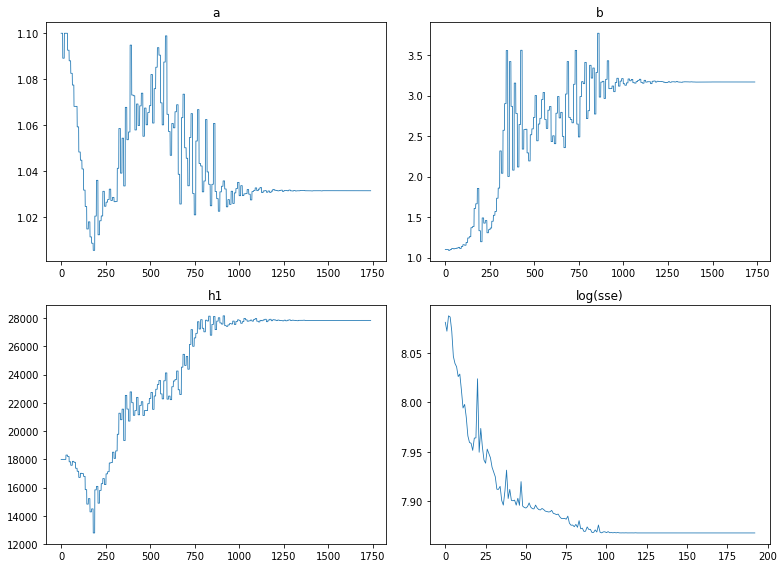

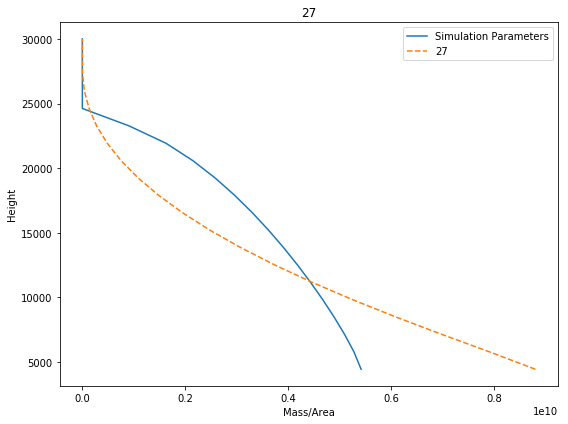

========LEFT OUT: (2287, 7844)========
a* = -3.42632	b* = 0.61709            	h1* = 2.59532
a = 1.03251	b = 2.85353	h1 = 27842.82799
Success: True, Optimization terminated successfully.
Iterations: 108
SSE: 2421.2807210837273


Height  Suspended Mass
0    4430.75    7.962262e+09
1    5776.50    7.297395e+09
2    7122.25    6.580190e+09
3    8468.00    5.864668e+09
4    9813.75    5.169450e+09
5   11159.50    4.503721e+09
6   12505.25    3.872986e+09
7   13851.00    3.281014e+09
8   15196.75    2.730653e+09
9   16542.50    2.224241e+09
10  17888.25    1.763831e+09
11  19234.00    1.351348e+09
12  20579.75    9.886978e+08
13  21925.50    6.778836e+08
14  23271.25    4.211374e+08
15  24617.00    2.211388e+08
16  25962.75    8.145788e+07
17  27308.50    7.925610e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

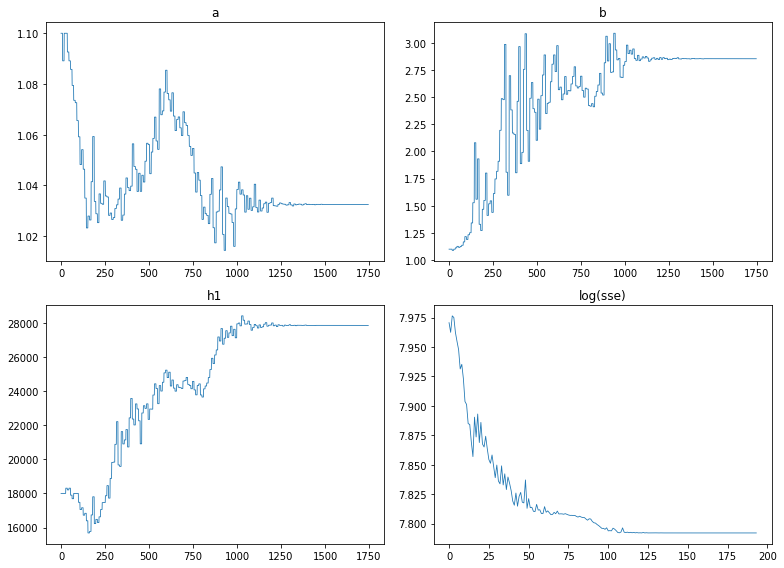

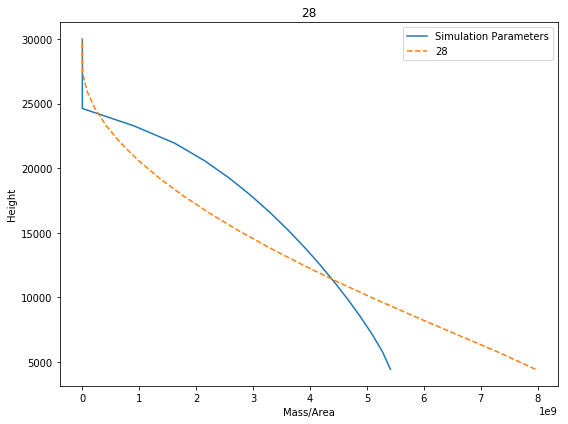

========LEFT OUT: (1907, 8096)========
a* = -3.45878	b* = 0.75710            	h1* = 2.58958
a = 1.03147	b = 3.13208	h1 = 27830.87771
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 2609.2258580122007


Height  Suspended Mass
0    4430.75    8.705819e+09
1    5776.50    7.842205e+09
2    7122.25    6.945141e+09
3    8468.00    6.072893e+09
4    9813.75    5.244989e+09
5   11159.50    4.470492e+09
6   12505.25    3.754290e+09
7   13851.00    3.099210e+09
8   15196.75    2.506910e+09
9   16542.50    1.978294e+09
10  17888.25    1.513740e+09
11  19234.00    1.113211e+09
12  20579.75    7.763112e+08
13  21925.50    5.022931e+08
14  23271.25    2.900206e+08
15  24617.00    1.378632e+08
16  25962.75    4.344212e+07
17  27308.50    2.875771e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

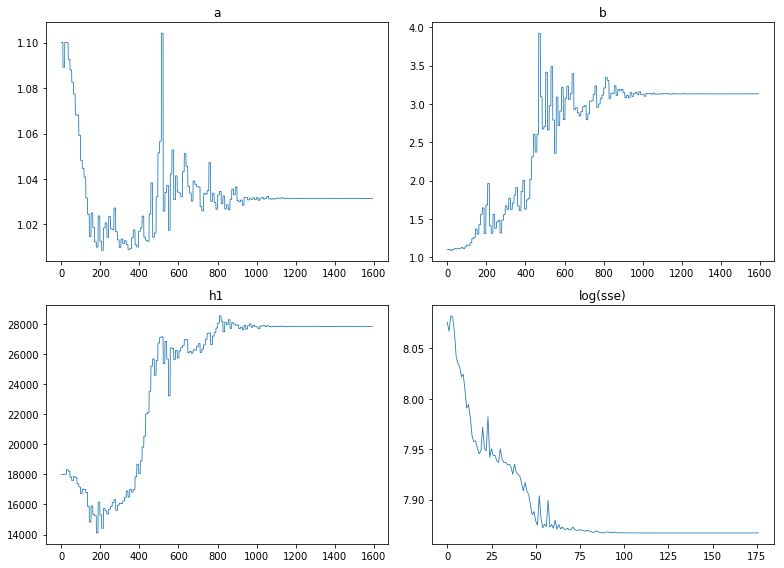

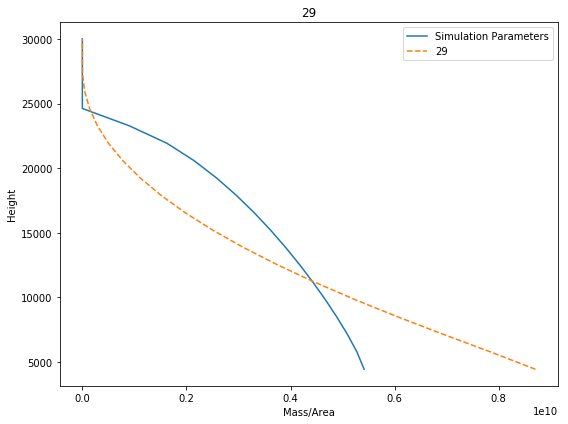

========LEFT OUT: (225, 8480)========
a* = -3.45739	b* = 0.75150            	h1* = 2.58965
a = 1.03151	b = 3.12018	h1 = 27831.00610
Success: True, Optimization terminated successfully.
Iterations: 94
SSE: 2601.8745907395896


Height  Suspended Mass
0    4430.75    8.674364e+09
1    5776.50    7.819623e+09
2    7122.25    6.930461e+09
3    8468.00    6.064986e+09
4    9813.75    5.242709e+09
5   11159.50    4.472720e+09
6   12505.25    3.759956e+09
7   13851.00    3.107308e+09
8   15196.75    2.516507e+09
9   16542.50    1.988545e+09
10  17888.25    1.523896e+09
11  19234.00    1.122630e+09
12  20579.75    7.844748e+08
13  21925.50    5.088228e+08
14  23271.25    2.947014e+08
15  24617.00    1.406765e+08
16  25962.75    4.461859e+07
17  27308.50    2.999918e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

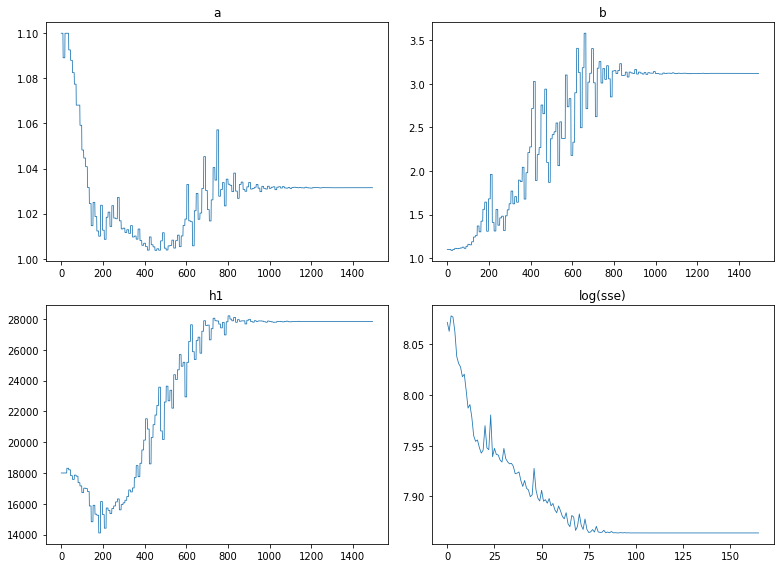

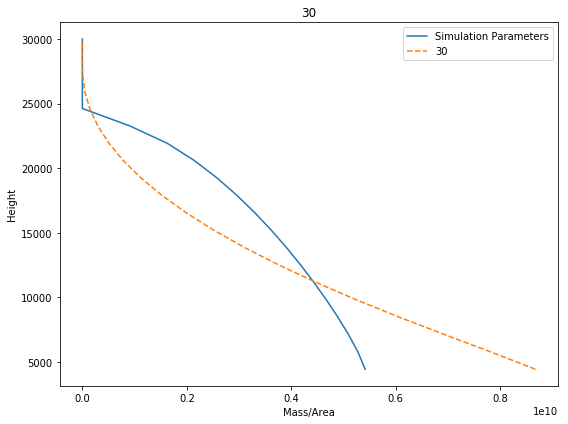

========LEFT OUT: (2424, 8963)========
a* = -3.45917	b* = 0.75955            	h1* = 2.58964
a = 1.03146	b = 3.13732	h1 = 27830.99110
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 2613.0762331527753


Height  Suspended Mass
0    4430.75    8.719538e+09
1    5776.50    7.852061e+09
2    7122.25    6.951543e+09
3    8468.00    6.076333e+09
4    9813.75    5.245968e+09
5   11159.50    4.469501e+09
6   12505.25    3.751799e+09
7   13851.00    3.095661e+09
8   15196.75    2.502711e+09
9   16542.50    1.973816e+09
10  17888.25    1.509311e+09
11  19234.00    1.109111e+09
12  20579.75    7.727649e+08
13  21925.50    4.994639e+08
14  23271.25    2.879994e+08
15  24617.00    1.366545e+08
16  25962.75    4.294119e+07
17  27308.50    2.824618e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

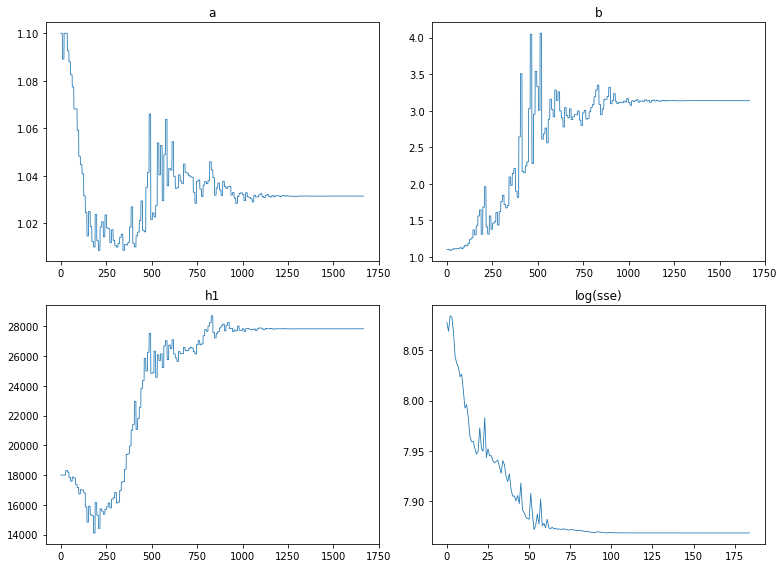

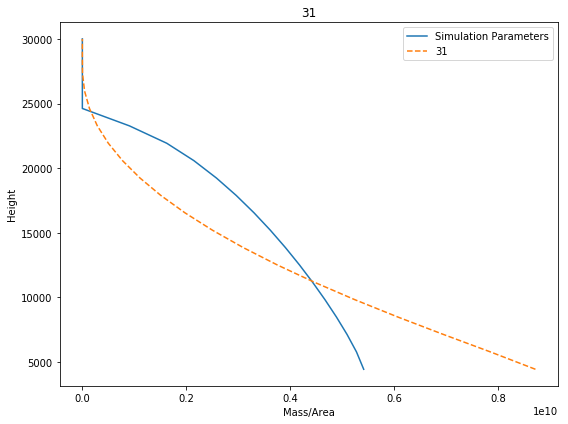

========LEFT OUT: (2665, 9054)========
a* = -3.45469	b* = 0.74001            	h1* = 2.58974
a = 1.03160	b = 3.09596	h1 = 27831.21106
Success: True, Optimization terminated successfully.
Iterations: 99
SSE: 2586.637527258716


Height  Suspended Mass
0    4430.75    8.610357e+09
1    5776.50    7.773534e+09
2    7122.25    6.900375e+09
3    8468.00    6.048650e+09
4    9813.75    5.237827e+09
5   11159.50    4.477042e+09
6   12505.25    3.771327e+09
7   13851.00    3.123695e+09
8   15196.75    2.536022e+09
9   16542.50    2.009466e+09
10  17888.25    1.544691e+09
11  19234.00    1.141981e+09
12  20579.75    8.013070e+08
13  21925.50    5.223415e+08
14  23271.25    3.044404e+08
15  24617.00    1.465683e+08
16  25962.75    4.710699e+07
17  27308.50    3.268440e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

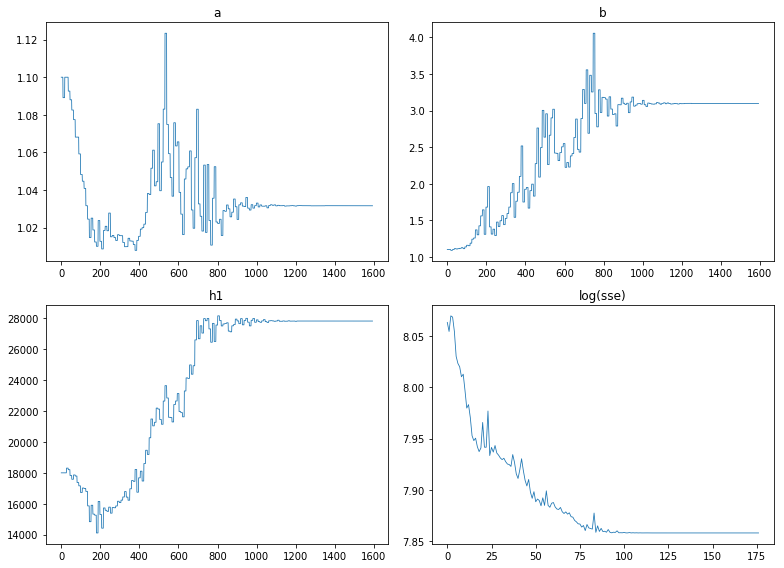

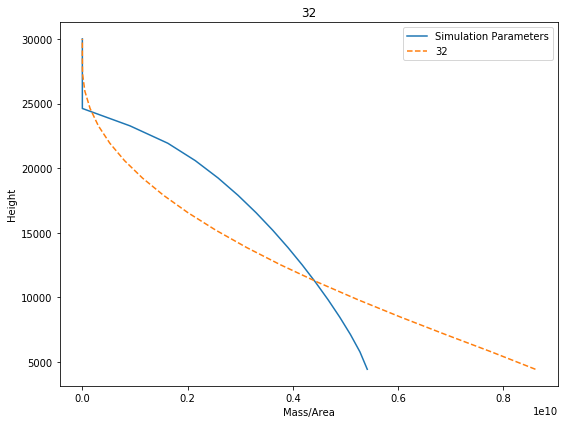

========LEFT OUT: (2979, 9056)========
a* = -3.44688	b* = 0.70846            	h1* = 2.59020
a = 1.03184	b = 3.03086	h1 = 27832.15653
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 2545.834562390486


Height  Suspended Mass
0    4430.75    8.437661e+09
1    5776.50    7.648398e+09
2    7122.25    6.817898e+09
3    8468.00    6.003015e+09
4    9813.75    5.223068e+09
5   11159.50    4.487284e+09
6   12505.25    3.800903e+09
7   13851.00    3.167225e+09
8   15196.75    2.588472e+09
9   16542.50    2.066209e+09
10  17888.25    1.601562e+09
11  19234.00    1.195349e+09
12  20579.75    8.481519e+08
13  21925.50    5.603592e+08
14  23271.25    3.321804e+08
15  24617.00    1.636371e+08
16  25962.75    5.450738e+07
17  27308.50    4.119784e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

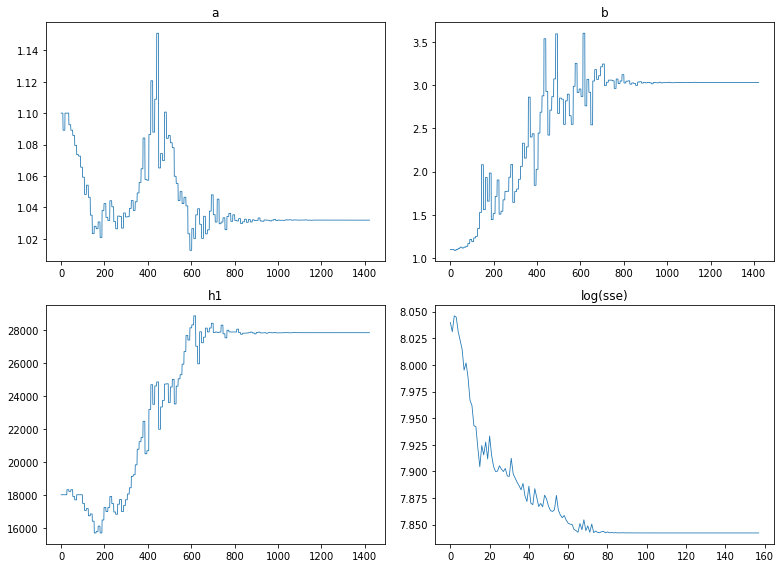

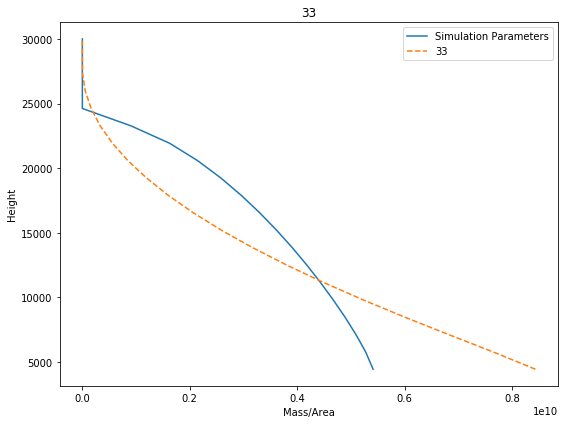

========LEFT OUT: (3133, 9522)========
a* = -3.45324	b* = 0.73364            	h1* = 2.59002
a = 1.03164	b = 3.08264	h1 = 27831.78534
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 2577.698196925816


Height  Suspended Mass
0    4430.75    8.574991e+09
1    5776.50    7.747983e+09
2    7122.25    6.883614e+09
3    8468.00    6.039463e+09
4    9813.75    5.234968e+09
5   11159.50    4.479289e+09
6   12505.25    3.777501e+09
7   13851.00    3.132683e+09
8   15196.75    2.546786e+09
9   16542.50    2.021057e+09
10  17888.25    1.556258e+09
11  19234.00    1.152789e+09
12  20579.75    8.107507e+08
13  21925.50    5.299659e+08
14  23271.25    3.099693e+08
15  24617.00    1.499437e+08
16  25962.75    4.855436e+07
17  27308.50    3.432155e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

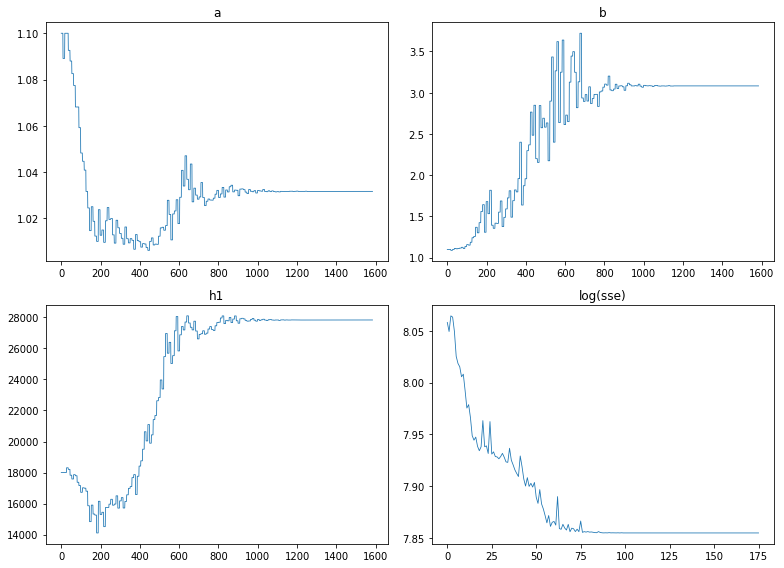

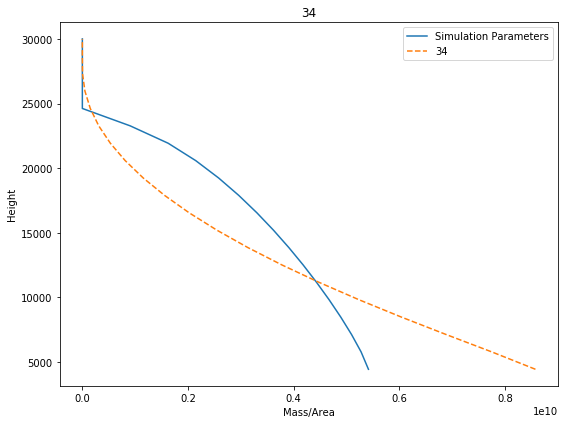

========LEFT OUT: (5500, 8723)========
a* = -3.45469	b* = 0.74059            	h1* = 2.58965
a = 1.03160	b = 3.09717	h1 = 27831.02115
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 2587.7820745003814


Height  Suspended Mass
0    4430.75    8.613576e+09
1    5776.50    7.775873e+09
2    7122.25    6.901916e+09
3    8468.00    6.049500e+09
4    9813.75    5.238097e+09
5   11159.50    4.476845e+09
6   12505.25    3.770768e+09
7   13851.00    3.122876e+09
8   15196.75    2.535039e+09
9   16542.50    2.008405e+09
10  17888.25    1.543630e+09
11  19234.00    1.140989e+09
12  20579.75    8.004386e+08
13  21925.50    5.216391e+08
14  23271.25    3.039297e+08
15  24617.00    1.462551e+08
16  25962.75    4.697122e+07
17  27308.50    3.252206e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

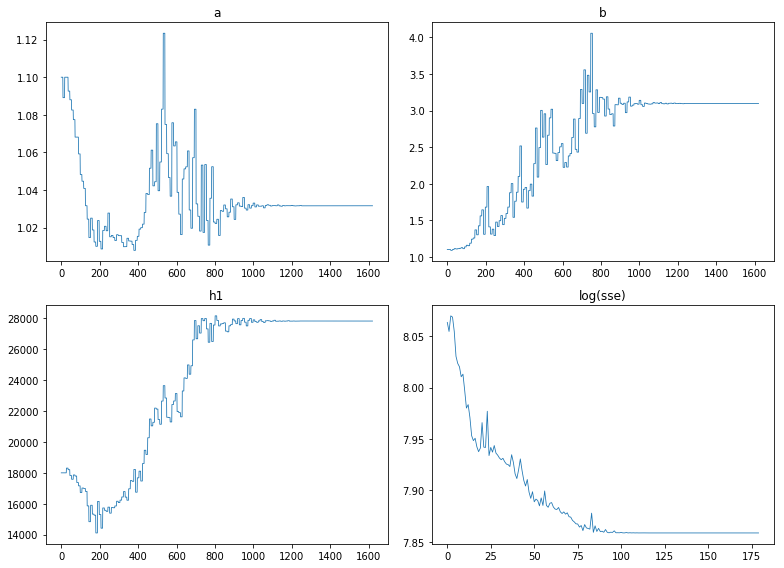

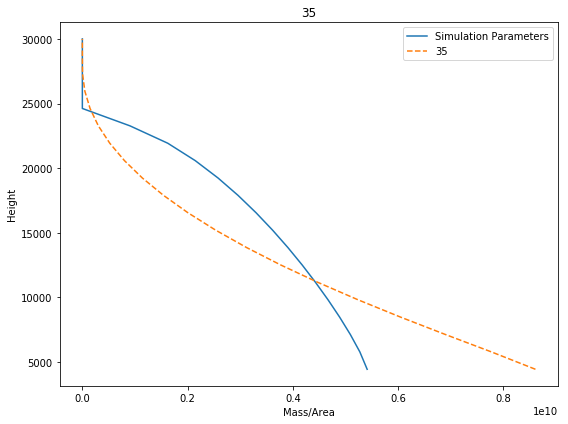

========LEFT OUT: (4617, 10199)========
a* = -3.45773	b* = 0.75548            	h1* = 2.58977
a = 1.03150	b = 3.12863	h1 = 27831.27478
Success: True, Optimization terminated successfully.
Iterations: 95
SSE: 2607.664638299795


Height  Suspended Mass
0    4430.75    8.696347e+09
1    5776.50    7.835469e+09
2    7122.25    6.940792e+09
3    8468.00    6.070572e+09
4    9813.75    5.244343e+09
5   11159.50    4.471181e+09
6   12505.25    3.755994e+09
7   13851.00    3.101631e+09
8   15196.75    2.509769e+09
9   16542.50    1.981343e+09
10  17888.25    1.516757e+09
11  19234.00    1.116007e+09
12  20579.75    7.787346e+08
13  21925.50    5.042326e+08
14  23271.25    2.914133e+08
15  24617.00    1.387035e+08
16  25962.75    4.379715e+07
17  27308.50    2.915443e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

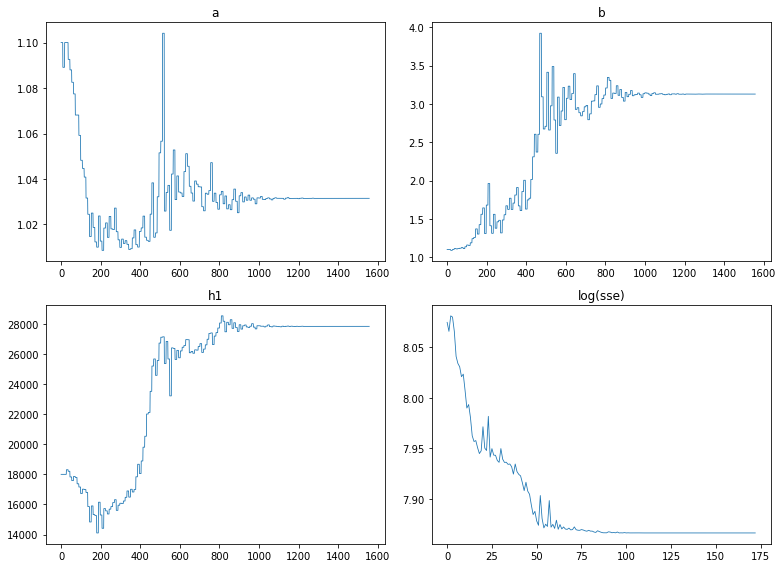

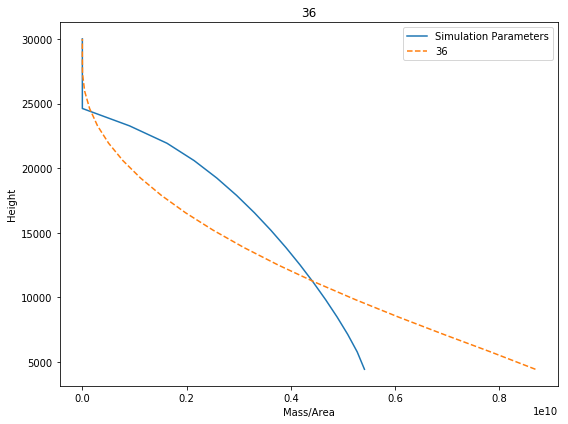

========LEFT OUT: (5132, 11365)========
a* = -3.42812	b* = 0.60428            	h1* = 2.60689
a = 1.03245	b = 2.82993	h1 = 27866.73775
Success: True, Optimization terminated successfully.
Iterations: 104
SSE: 2414.2879009979606


Height  Suspended Mass
0    4430.75    7.893169e+09
1    5776.50    7.244716e+09
2    7122.25    6.543082e+09
3    8468.00    5.841602e+09
4    9813.75    5.158674e+09
5   11159.50    4.503399e+09
6   12505.25    3.881260e+09
7   13851.00    3.296033e+09
8   15196.75    2.750602e+09
9   16542.50    2.247356e+09
10  17888.25    1.788426e+09
11  19234.00    1.375831e+09
12  20579.75    1.011601e+09
13  21925.50    6.978979e+08
14  23271.25    4.371638e+08
15  24617.00    2.323699e+08
16  25962.75    8.752937e+07
17  27308.50    9.287335e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

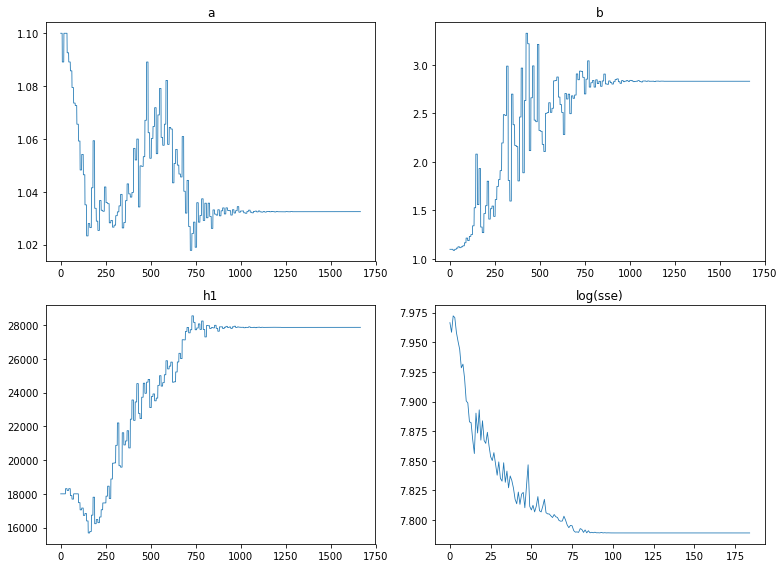

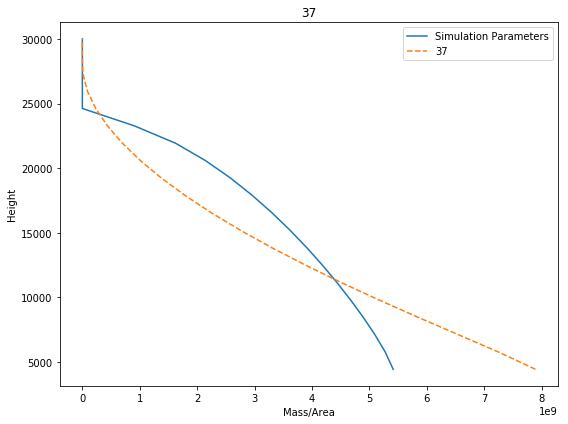

In [57]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
sse_list = []
for i in range(len(df)):
    loo_df = df.copy()
    loo_df = loo_df.drop(index=i)
    row = df.iloc[i]
    print("========LEFT OUT: (%s, %s)========"%(str(row["Easting"]),
                                                str(row["Northing"])))
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=i)
    ax1.legend()
    ax1.set_title("%s"%str(i))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Coordinate Removed  Distance from Vent         a         b  Column Height  \
0        (1499, 1506)         2124.861643  1.031127  3.172443   27845.246942   
1        (1957, 1997)         2796.043276  1.031334  3.158329   27837.541207   
2        (1787, 2173)         2813.413940  1.031054  3.287808   27825.280691   
3        (-770, 3082)         3176.731654  1.031351  3.169013   27831.128015   
4       (-1673, 3152)         3568.477687  1.031406  3.153712   27829.885797   
5        (-637, 4876)         4917.432765  1.031532  3.113611   27831.081228   
6       (-1268, 5048)         5204.817768  1.031498  3.125092   27828.794968   
7       (-2101, 5517)         5903.515055  1.031395  3.154491   27831.541674   
8       (-2250, 5771)         6194.105343  1.031474  3.130672   27833.667933   
9       (-2272, 5925)         6345.676402  1.030742  3.376074   27832.277697   
10         (32, 6398)         6398.080025  1.029227  4.333940   27830.112803   
11       (-337, 6683)         6691.491463  1.031462  3.156834   27816.628633   
12       (2519, 6318)         6801.653108  1.031427  3.160755   27824.004965   
13      (-1439, 6652)         6805.866954  1.031439  3.136360   27832.343109   
14       (5823, 3944)         7032.955638  1.031490  3.127159   27830.488379   
15       (4688, 5396)         7148.017907  1.031295  3.171461   27837.614415   
16        (918, 7180)         7238.447624  1.030612  3.391908   27899.619009   
17       (4337, 6035)         7431.742326  1.031541  3.132660   27802.879102   
18       (2019, 7255)         7530.696249  1.031177  3.192212   27799.067240   
19       (-586, 7588)         7610.593932  1.031340  3.159649   27837.802787   
20       (-387, 7656)         7665.774912  1.031419  3.150753   27821.271339   
21       (-555, 7666)         7686.064077  1.031460  3.183132   27815.629464   
22       (3512, 6869)         7714.745945  1.031305  3.203093   27833.691175   
23       (3226, 7110)         7807.635750  1.031997  3.010128   27816.354081   
24       (1154, 7735)         7820.610015  1.031555  3.125475   27811.776096   
25       (2037, 7565)         7834.449183  1.031388  3.175940   27838.901555   
26       (3352, 7167)         7912.129486  1.031409  3.178526   27824.582589   
27       (3066, 7419)         8027.572298  1.031348  3.168464   27833.720733   
28       (2287, 7844)         8170.600039  1.032506  2.853526   27842.827995   
29       (1907, 8096)         8317.563646  1.031468  3.132077   27830.877712   
30        (225, 8480)         8482.984439  1.031512  3.120176   27831.006099   
31       (2424, 8963)         9284.995692  1.031456  3.137321   27830.991105   
32       (2665, 9054)         9438.068711  1.031597  3.095955   27831.211064   
33       (2979, 9056)         9533.392733  1.031845  3.030863   27832.156529   
34       (3133, 9522)        10024.179418  1.031643  3.082638   27831.785336   
35       (5500, 8723)        10312.164128  1.031597  3.097167   27831.021148   
36      (4617, 10199)        11195.369132  1.031501  3.128628   27831.274779   
37      (5132, 11365)        12469.989936  1.032448  2.829929   27866.737752   

    Goodness of Fit  
0       2600.391808  
1       2611.045091  
2       2697.380649  
3       2622.568470  
4       2621.292222  
5       2596.990879  
6       2599.558229  
7       2620.223828  
8       2606.025274  
9       2744.431961  
10      3191.225178  
11      2623.135694  
12      2620.321932  
13      2610.293971  
14      2605.881783  
15      2620.326859  
16      2176.968022  
17      2325.763672  
18      2328.157507  
19      2614.865021  
20      2616.868315  
21      2622.938930  
22      2607.905640  
23      2530.838045  
24      2597.468221  
25      2622.545625  
26      2622.655237  
27      2612.464782  
28      2421.280721  
29      2609.225858  
30      2601.874591  
31      2613.076233  
32      2586.637527  
33      2545.834562  
34      2577.698197  
35      2587.782075  
36      2607.664638  
37      2414.287901

\begin{tabular}{lrrrrr}
\toprule
Coordinate Removed &  Distance from Vent &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
      (1499, 1506) &             2124.86 & 1.03 & 3.17 &       27845.25 &          2600.39 \\
      (1957, 1997) &             2796.04 & 1.03 & 3.16 &       27837.54 &          2611.05 \\
      (1787, 2173) &             2813.41 & 1.03 & 3.29 &       27825.28 &          2697.38 \\
      (-770, 3082) &             3176.73 & 1.03 & 3.17 &       27831.13 &          2622.57 \\
     (-1673, 3152) &             3568.48 & 1.03 & 3.15 &       27829.89 &          2621.29 \\
      (-637, 4876) &             4917.43 & 1.03 & 3.11 &       27831.08 &          2596.99 \\
     (-1268, 5048) &             5204.82 & 1.03 & 3.13 &       27828.79 &          2599.56 \\
     (-2101, 5517) &             5903.52 & 1.03 & 3.15 &       27831.54 &          2620.22 \\
     (-2250, 5771) &             6194.11 & 1.03 & 3.13 &       27833.67 &          2606.03 \\
     (-2272, 5925)

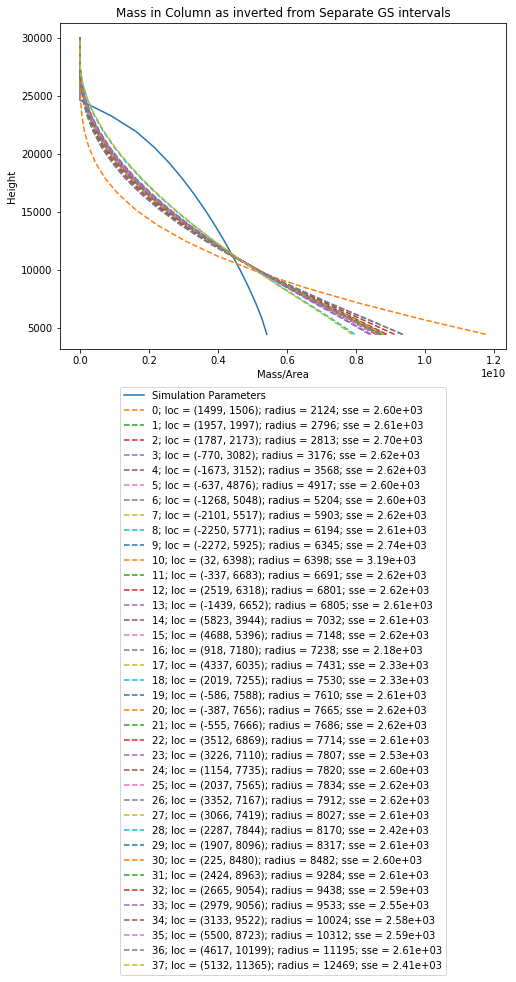

In [58]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                            config["VENT_ELEVATION"], 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"],
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

table = pd.DataFrame(columns=[
    "Coordinate Removed", 
    "Distance from Vent", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

for i, mass, sse in zip(range(len(df)), inverted_masses_list, sse_list):
    row=df.iloc[i]
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="%d; loc = (%d, %d); radius = %d; sse = %.2e"%(
             i, 
             row["Easting"], 
             row["Northing"], 
             row["radius"],
             sse))
    table = table.append({
        "Coordinate Removed": "(%d, %d)"%(row["Easting"], row["Northing"]),
        "Distance from Vent": row["radius"],
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()
plt.savefig("data/colima/PNT_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/PNT_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

## Left out Sections

In [59]:
sectors = [
    (0, 2000),
    (2000, 4000),
    (4000, 6000),
    (6000, 8000),
    (8000, 10000),
    (10000, 12000),
    (12000, 14000),
]

# sectors = [
#     (0, 3000),
#     (3000, 6000),
#     (6000, 9000),
#     (9000, 12000),
#     (12000, 15000),
# ]

# sectors = [
#     (0, 4000),
#     (4000, 8000),
#     (8000, 12000),
#     (12000, 16000),
# ]

========LEFT OUT BETWEEN: 0 m and 2000 m========
Points left out: 0
a* = -3.46064	b* = 0.76566            	h1* = 2.58957
a = 1.03141	b = 3.15041	h1 = 27830.85222
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 2620.232761043232


Height  Suspended Mass
0    4430.75    8.754080e+09
1    5776.50    7.876800e+09
2    7122.25    6.967565e+09
3    8468.00    6.084897e+09
4    9813.75    5.248352e+09
5   11159.50    4.466947e+09
6   12505.25    3.745494e+09
7   13851.00    3.086719e+09
8   15196.75    2.492159e+09
9   16542.50    1.962584e+09
10  17888.25    1.498219e+09
11  19234.00    1.098857e+09
12  20579.75    7.639089e+08
13  21925.50    4.924088e+08
14  23271.25    2.829668e+08
15  24617.00    1.336493e+08
16  25962.75    4.169682e+07
17  27308.50    2.696290e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

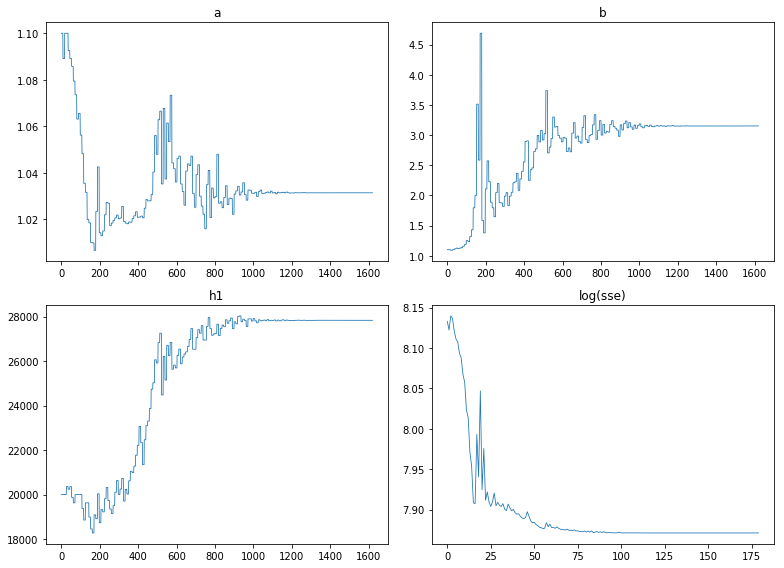

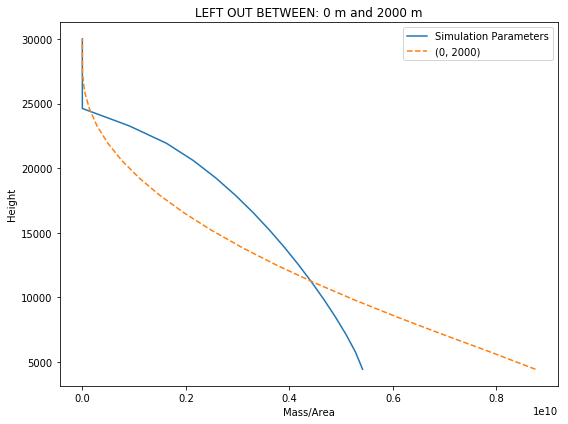

========LEFT OUT BETWEEN: 2000 m and 4000 m========
Points left out: 5
a* = -3.41592	b* = 0.23148            	h1* = 2.94285
a = 1.03285	b = 2.26047	h1 = 28459.50518
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 1514.8672869007582


Height  Suspended Mass
0    4430.75    6.219165e+09
1    5776.50    5.916563e+09
2    7122.25    5.551021e+09
3    8468.00    5.161954e+09
4    9813.75    4.762650e+09
5   11159.50    4.359551e+09
6   12505.25    3.956494e+09
7   13851.00    3.556119e+09
8   15196.75    3.160473e+09
9   16542.50    2.771312e+09
10  17888.25    2.390285e+09
11  19234.00    2.019070e+09
12  20579.75    1.659509e+09
13  21925.50    1.313769e+09
14  23271.25    9.845939e+08
15  24617.00    6.757783e+08
16  25962.75    3.932432e+08
17  27308.50    1.484510e+08
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

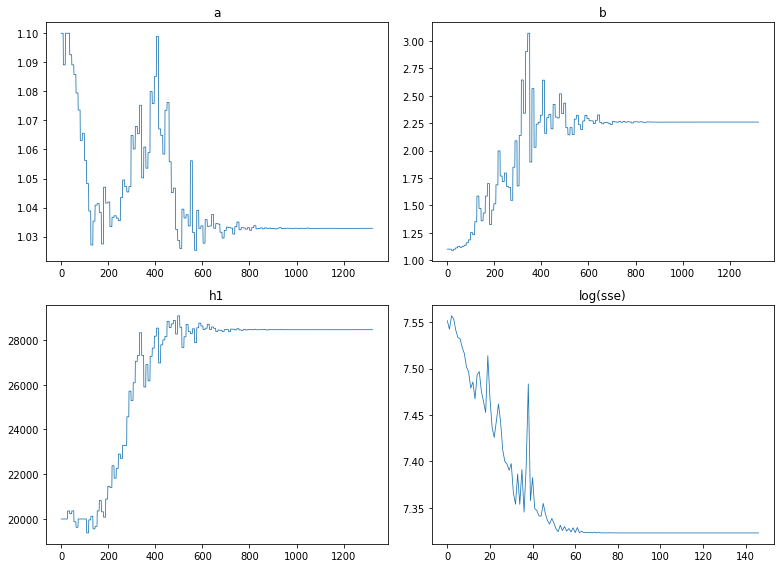

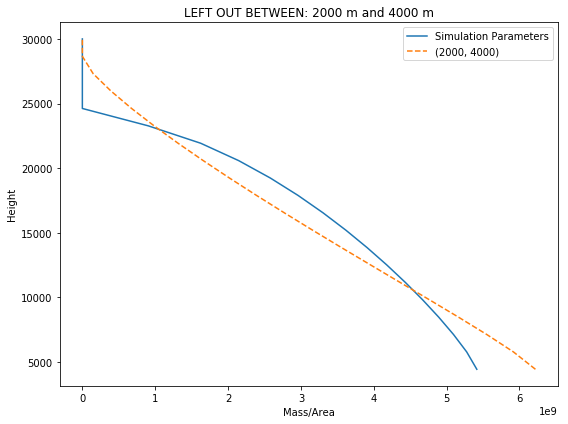

========LEFT OUT BETWEEN: 4000 m and 6000 m========
Points left out: 3
a* = -3.44357	b* = 0.69698            	h1* = 2.59051
a = 1.03195	b = 3.00769	h1 = 27832.81185
Success: True, Optimization terminated successfully.
Iterations: 90
SSE: 2531.471872814047


Height  Suspended Mass
0    4430.75    8.375747e+09
1    5776.50    7.603288e+09
2    7122.25    6.787900e+09
3    8468.00    5.986125e+09
4    9813.75    5.217224e+09
5   11159.50    4.490448e+09
6   12505.25    3.811098e+09
7   13851.00    3.182563e+09
8   15196.75    2.607175e+09
9   16542.50    2.086626e+09
10  17888.25    1.622195e+09
11  19234.00    1.214872e+09
12  20579.75    8.654440e+08
13  21925.50    5.745387e+08
14  23271.25    3.426581e+08
15  24617.00    1.701938e+08
16  25962.75    5.742569e+07
17  27308.50    4.478393e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

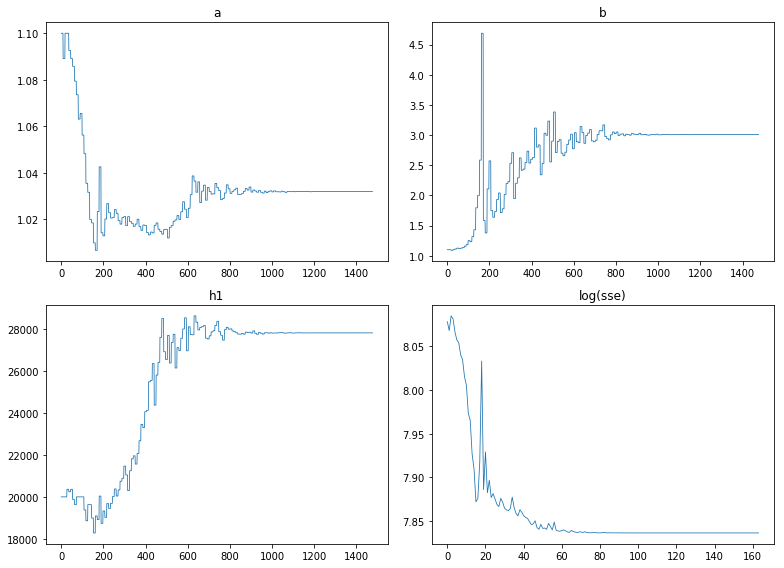

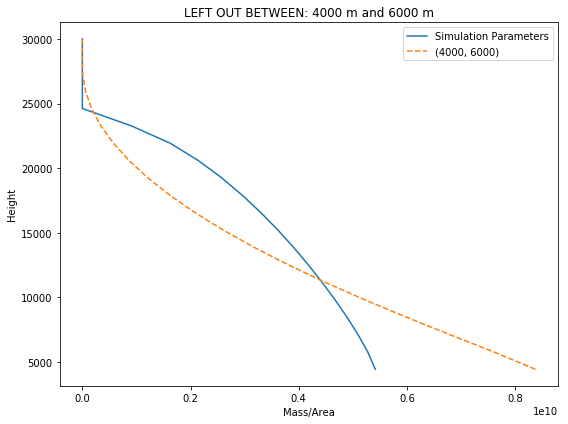

========LEFT OUT BETWEEN: 6000 m and 8000 m========
Points left out: 19
a* = -3.33417	b* = 0.37929            	h1* = 2.55040
a = 1.03564	b = 2.46125	h1 = 27747.54265
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 2066.065007297832


Height  Suspended Mass
0    4430.75    6.915902e+09
1    5776.50    6.499083e+09
2    7122.25    6.011966e+09
3    8468.00    5.503643e+09
4    9813.75    4.990975e+09
5   11159.50    4.482341e+09
6   12505.25    3.982885e+09
7   13851.00    3.496271e+09
8   15196.75    3.025443e+09
9   16542.50    2.573014e+09
10  17888.25    2.141505e+09
11  19234.00    1.733535e+09
12  20579.75    1.352010e+09
13  21925.50    1.000372e+09
14  23271.25    6.829951e+08
15  24617.00    4.059626e+08
16  25962.75    1.789916e+08
17  27308.50    2.310454e+07
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

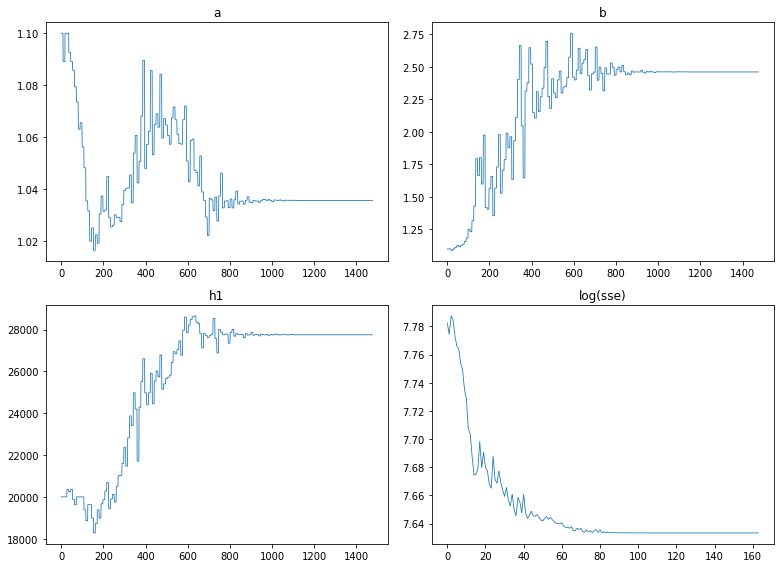

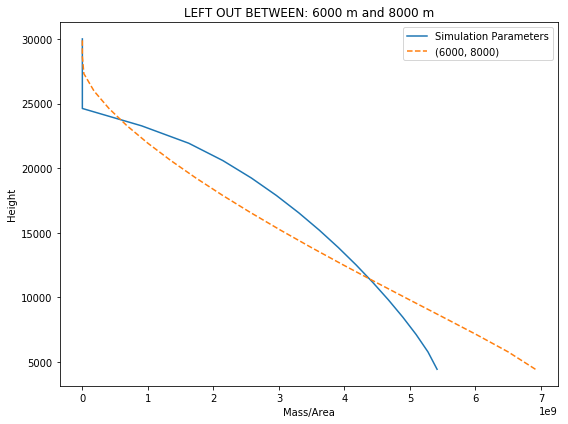

========LEFT OUT BETWEEN: 8000 m and 10000 m========
Points left out: 7
a* = -3.46826	b* = 0.79304            	h1* = 2.60436
a = 1.03117	b = 3.21011	h1 = 27861.53981
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 2583.984823647934


Height  Suspended Mass
0    4430.75    8.900574e+09
1    5776.50    7.980433e+09
2    7122.25    7.033473e+09
3    8468.00    6.118835e+09
4    9813.75    5.256068e+09
5   11159.50    4.453986e+09
6   12505.25    3.717095e+09
7   13851.00    3.047750e+09
8   15196.75    2.447063e+09
9   16542.50    1.915330e+09
10  17888.25    1.452250e+09
11  19234.00    1.057035e+09
12  20579.75    7.284517e+08
13  21925.50    4.648102e+08
14  23271.25    2.638978e+08
15  24617.00    1.228214e+08
16  25962.75    3.765772e+07
17  27308.50    2.469590e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

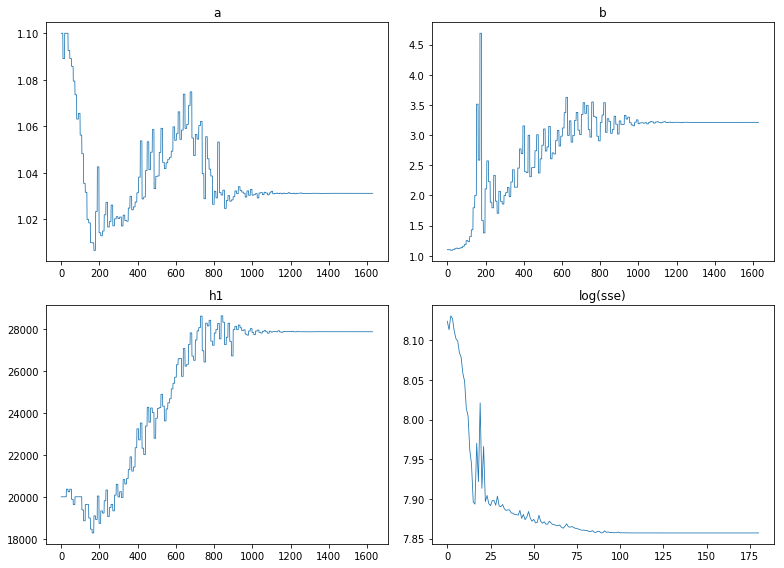

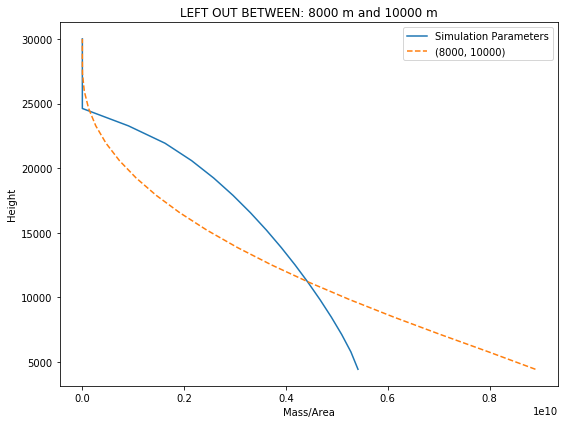

========LEFT OUT BETWEEN: 10000 m and 12000 m========
Points left out: 3
a* = -3.50424	b* = 0.96707            	h1* = 2.59429
a = 1.03007	b = 3.63022	h1 = 27840.68405
Success: True, Optimization terminated successfully.
Iterations: 103
SSE: 2837.6947746617525


Height  Suspended Mass
0    4430.75    9.996402e+09
1    5776.50    8.735071e+09
2    7122.25    7.493331e+09
3    8468.00    6.334549e+09
4    9813.75    5.277013e+09
5   11159.50    4.326570e+09
6   12505.25    3.483956e+09
7   13851.00    2.747272e+09
8   15196.75    2.113029e+09
9   16542.50    1.576642e+09
10  17888.25    1.132679e+09
11  19234.00    7.749848e+08
12  20579.75    4.967226e+08
13  21925.50    2.903542e+08
14  23271.25    1.475590e+08
15  24617.00    5.906139e+07
16  25962.75    1.428418e+07
17  27308.50    5.190905e+05
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

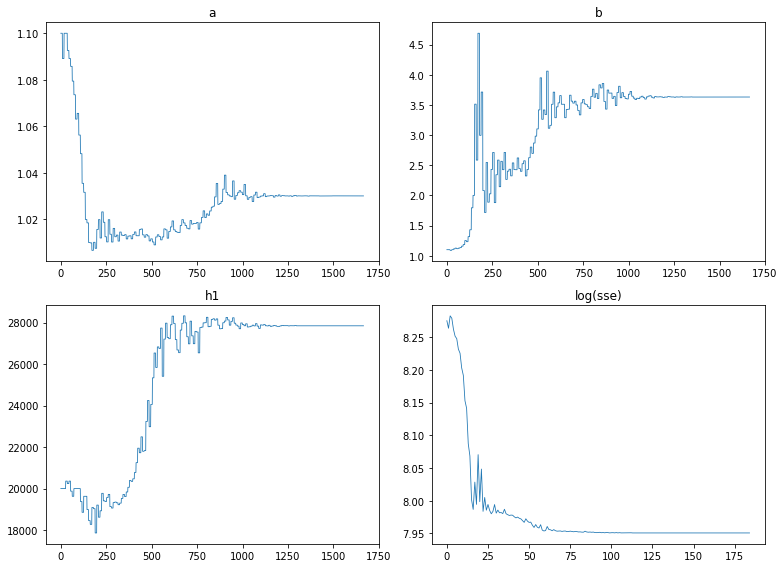

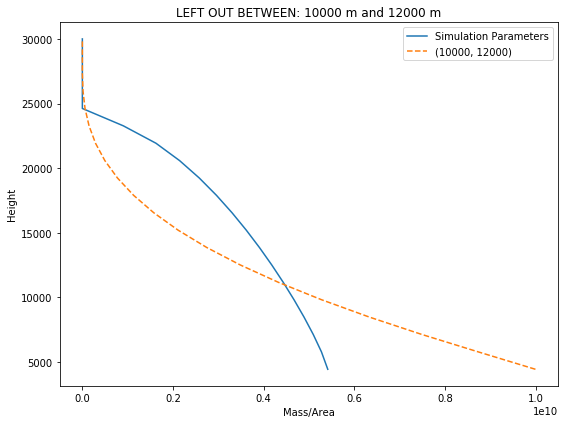

========LEFT OUT BETWEEN: 12000 m and 14000 m========
Points left out: 1
a* = -3.53262	b* = 1.20413            	h1* = 2.58919
a = 1.02923	b = 4.33386	h1 = 27830.06291
Success: True, Optimization terminated successfully.
Iterations: 113
SSE: 3191.2251776368767


Height  Suspended Mass
0    4430.75    1.176248e+10
1    5776.50    9.852266e+09
2    7122.25    8.082024e+09
3    8468.00    6.514502e+09
4    9813.75    5.157171e+09
5   11159.50    4.002420e+09
6   12505.25    3.036756e+09
7   13851.00    2.244021e+09
8   15196.75    1.606804e+09
9   16542.50    1.107179e+09
10  17888.25    7.271375e+08
11  19234.00    4.488844e+08
12  20579.75    2.550560e+08
13  21925.50    1.289138e+08
14  23271.25    5.453345e+07
15  24617.00    1.702004e+07
16  25962.75    2.792110e+06
17  27308.50    3.981064e+04
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

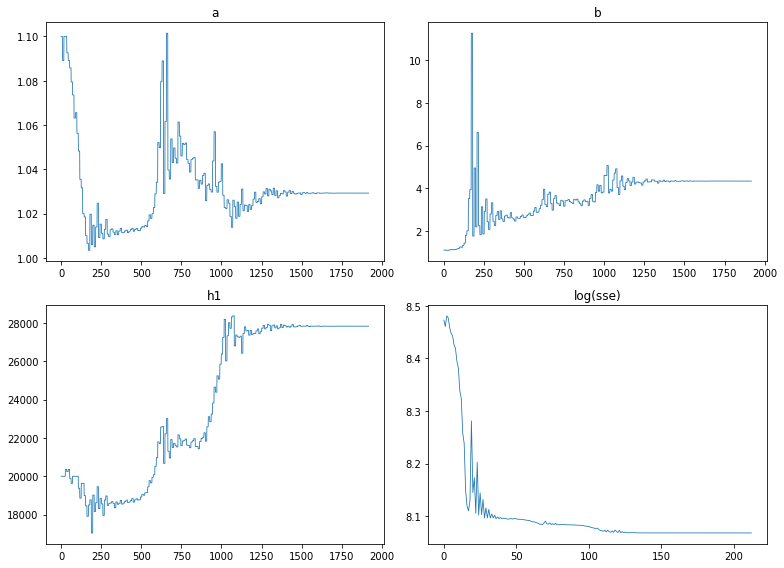

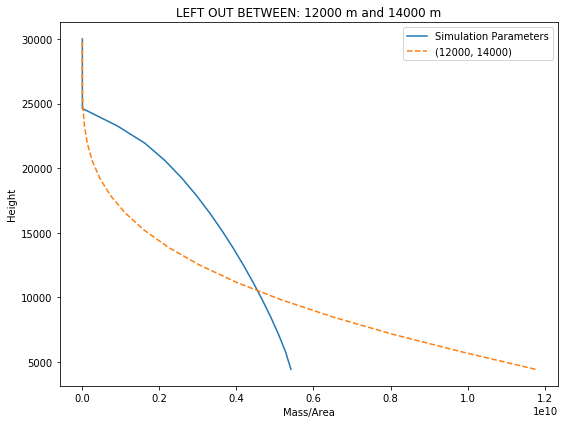

In [60]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 20000
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

inverted_masses_list = []
params_list = []
sse_list = []
numpoints_list = []
for i, sec in enumerate(sectors):
    loo_df = df.copy()
    loo_df = loo_df[(loo_df["radius"]<=sec[0])|(loo_df["radius"]>sec[1])]
    
    print("========LEFT OUT BETWEEN: %s m and %s m========"%(str(sec[0]),
                                                             str(sec[1])))
    
    num_points = len(df) - len(loo_df)
    print("Points left out: %s"%(num_points))
    numpoints_list += [num_points]
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=str(sec))
    ax1.legend()
    ax1.set_title("LEFT OUT BETWEEN: %s m and %s m"%(str(sec[0]), str(sec[1])))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Sector Removed Points dropped         a         b  Column Height  \
0       (0, 2000)              0  1.031410  3.150409   27830.852218   
1    (2000, 4000)              5  1.032846  2.260467   28459.505183   
2    (4000, 6000)              3  1.031950  3.007686   27832.811853   
3    (6000, 8000)             19  1.035644  2.461251   27747.542654   
4   (8000, 10000)              7  1.031171  3.210113   27861.539807   
5  (10000, 12000)              3  1.030070  3.630223   27840.684051   
6  (12000, 14000)              1  1.029228  4.333859   27830.062908   

   Goodness of Fit  
0      2620.232761  
1      1514.867287  
2      2531.471873  
3      2066.065007  
4      2583.984824  
5      2837.694775  
6      3191.225178

\begin{tabular}{llrrrr}
\toprule
 Sector Removed & Points dropped &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
      (0, 2000) &              0 & 1.03 & 3.15 &       27830.85 &          2620.23 \\
   (2000, 4000) &              5 & 1.03 & 2.26 &       28459.51 &          1514.87 \\
   (4000, 6000) &              3 & 1.03 & 3.01 &       27832.81 &          2531.47 \\
   (6000, 8000) &             19 & 1.04 & 2.46 &       27747.54 &          2066.07 \\
  (8000, 10000) &              7 & 1.03 & 3.21 &       27861.54 &          2583.98 \\
 (10000, 12000) &              3 & 1.03 & 3.63 &       27840.68 &          2837.69 \\
 (12000, 14000) &              1 & 1.03 & 4.33 &       27830.06 &          3191.23 \\
\bottomrule
\end{tabular}



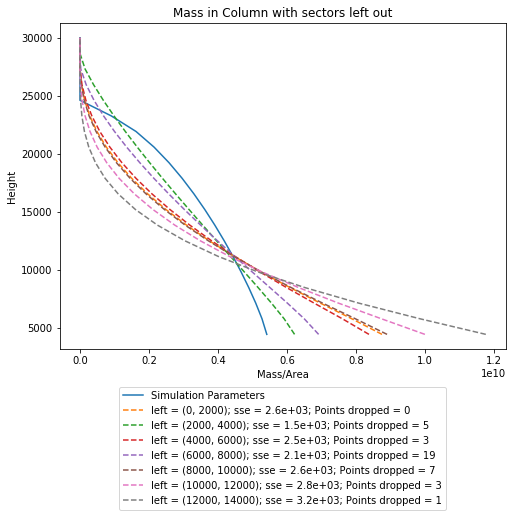

In [61]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                            config["VENT_ELEVATION"], 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"],
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

table = pd.DataFrame(columns=[
    "Sector Removed", 
    "Points dropped", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

for i, sec, mass, sse, numpts in zip(list(range(len(sectors))), sectors, inverted_masses_list, sse_list, numpoints_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="left = (%d, %d); sse = %.2g; Points dropped = %s"%(
             sec[0],
             sec[1],
             sse, 
             numpts
         ))
    table = table.append({
        "Sector Removed": "(%d, %d)"%(sec[0], sec[1]),
        "Points dropped": numpts,
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column with sectors left out")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()

plt.savefig("data/colima/SEC_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/SEC_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

## Left Out Phi Classes

========LEFT OUT: [-5,-4)========


38

a* = -3.46926	b* = 0.74660            	h1* = 2.54282
a = 1.03114	b = 3.10980	h1 = 27731.06108
Success: True, Optimization terminated successfully.
Iterations: 304
SSE: 2490.2578306087653


Height  Suspended Mass
0    4430.75    8.686524e+09
1    5776.50    7.829052e+09
2    7122.25    6.937971e+09
3    8468.00    6.070822e+09
4    9813.75    5.246948e+09
5   11159.50    4.475383e+09
6   12505.25    3.761058e+09
7   13851.00    3.106883e+09
8   15196.75    2.514622e+09
9   16542.50    1.985312e+09
10  17888.25    1.519485e+09
11  19234.00    1.117278e+09
12  20579.75    7.784939e+08
13  21925.50    5.026118e+08
14  23271.25    2.887584e+08
15  24617.00    1.356127e+08
16  25962.75    4.117153e+07
17  27308.50    2.012657e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

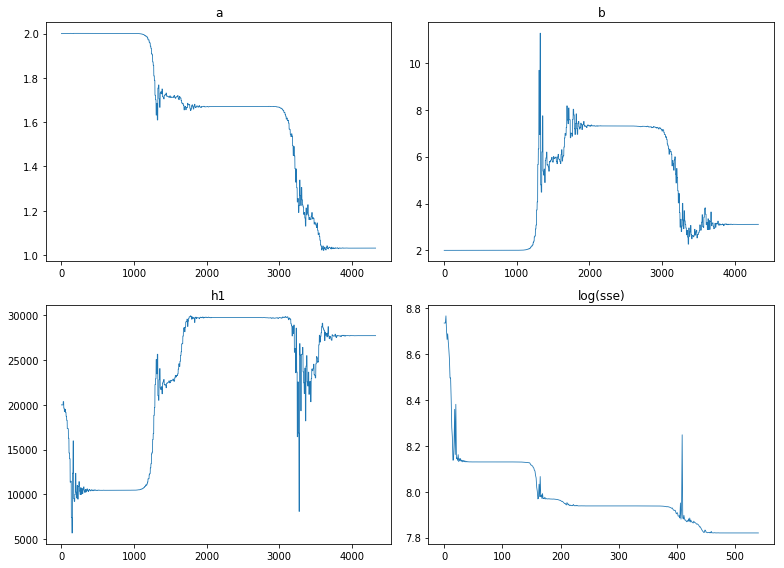

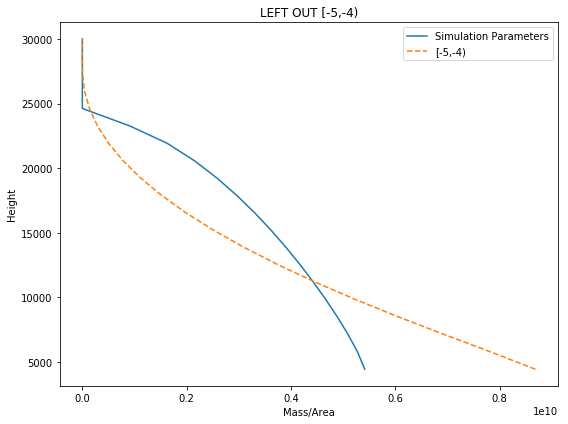

========LEFT OUT: [-4,-3)========


38

a* = -3.46802	b* = 0.83419            	h1* = 2.52153
a = 1.03118	b = 3.30294	h1 = 27684.17258
Success: True, Optimization terminated successfully.
Iterations: 260
SSE: 2427.1375910319543


Height  Suspended Mass
0    4430.75    9.204830e+09
1    5776.50    8.199303e+09
2    7122.25    7.175655e+09
3    8468.00    6.195236e+09
4    9813.75    5.277922e+09
5   11159.50    4.432281e+09
6   12505.25    3.662307e+09
7   13851.00    2.969685e+09
8   15196.75    2.354734e+09
9   16542.50    1.816860e+09
10  17888.25    1.354772e+09
11  19234.00    9.665899e+08
12  20579.75    6.498754e+08
13  21925.50    4.015973e+08
14  23271.25    2.180290e+08
15  24617.00    9.452599e+07
16  25962.75    2.504253e+07
17  27308.50    7.534074e+05
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

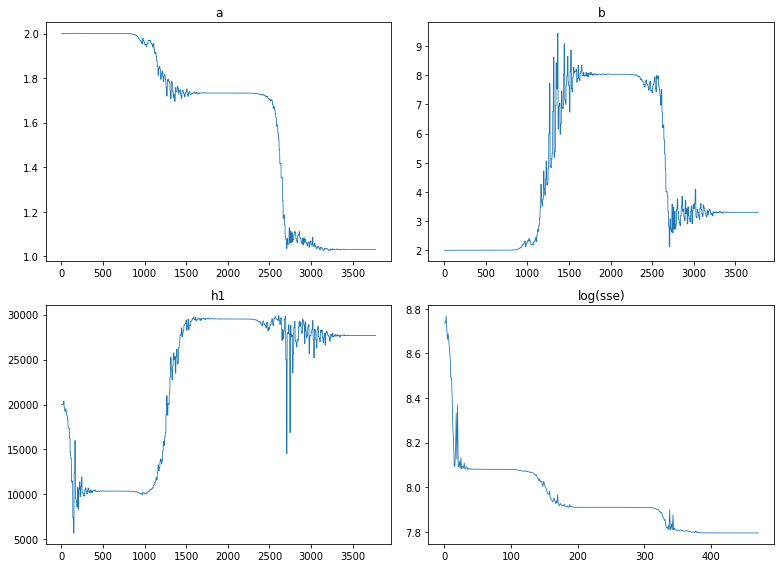

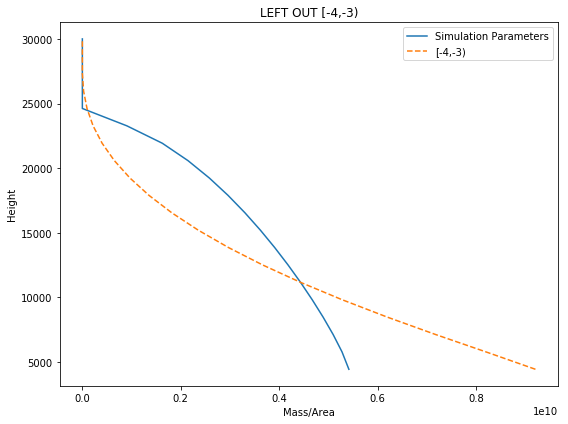

========LEFT OUT: [-3,-2)========


38

a* = -3.47666	b* = 1.01815            	h1* = 2.52956
a = 1.03091	b = 3.76807	h1 = 27701.96133
Success: True, Optimization terminated successfully.
Iterations: 250
SSE: 2226.0002899276724


Height  Suspended Mass
0    4430.75    1.039057e+10
1    5776.50    9.001886e+09
2    7122.25    7.649417e+09
3    8468.00    6.400155e+09
4    9813.75    5.272137e+09
5   11159.50    4.269840e+09
6   12505.25    3.392158e+09
7   13851.00    2.635113e+09
8   15196.75    1.993006e+09
9   16542.50    1.458975e+09
10  17888.25    1.025277e+09
11  19234.00    6.834428e+08
12  20579.75    4.243432e+08
13  21925.50    2.382032e+08
14  23271.25    1.145576e+08
15  24617.00    4.213892e+07
16  25962.75    8.640348e+06
17  27308.50    1.414637e+05
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

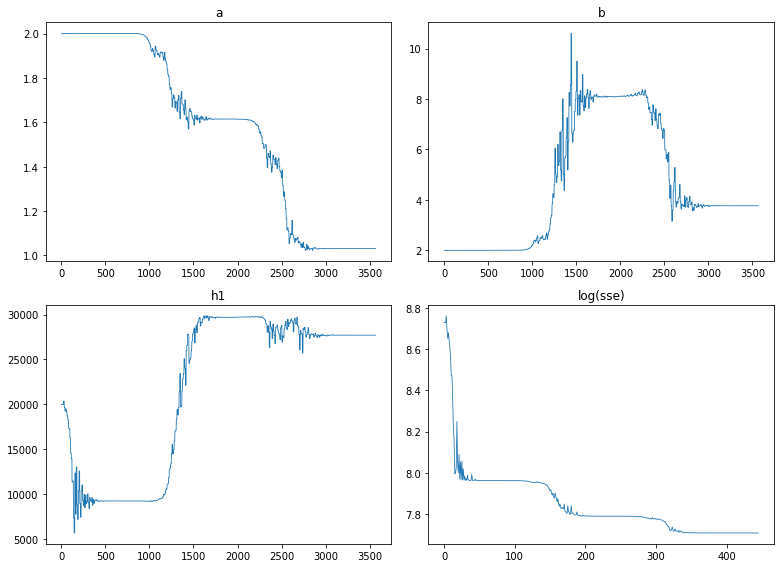

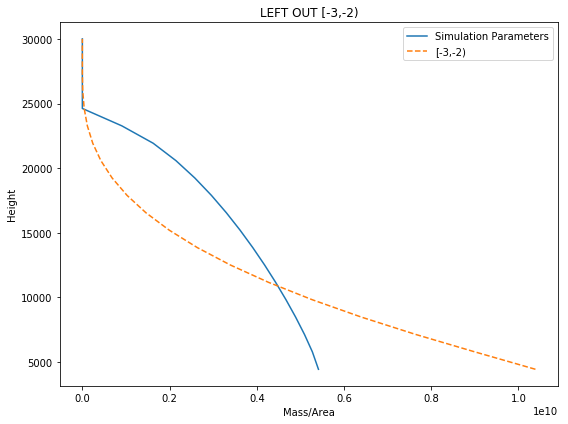

========LEFT OUT: [-2,-1)========


38

C:\Users\nmostert\Documents\repos\inversion_project\utils.py:426: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -3.50271	b* = 1.16971            	h1* = 2.61370
a = 1.03012	b = 4.22104	h1 = 27880.69638
Success: True, Optimization terminated successfully.
Iterations: 252
SSE: 2218.652241908512


Height  Suspended Mass
0    4430.75    1.145200e+10
1    5776.50    9.666562e+09
2    7122.25    7.992920e+09
3    8468.00    6.496909e+09
4    9813.75    5.189496e+09
5   11159.50    4.066555e+09
6   12505.25    3.117951e+09
7   13851.00    2.330689e+09
8   15196.75    1.690297e+09
9   16542.50    1.181524e+09
10  17888.25    7.887579e+08
11  19234.00    4.962844e+08
12  20579.75    2.884856e+08
13  21925.50    1.499981e+08
14  23271.25    6.586516e+07
15  24617.00    2.170401e+07
16  25962.75    3.923559e+06
17  27308.50    7.988074e+04
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

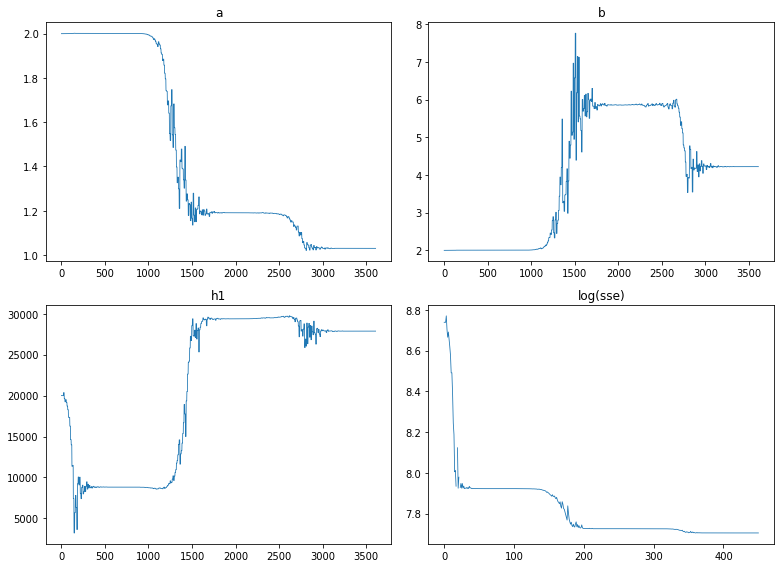

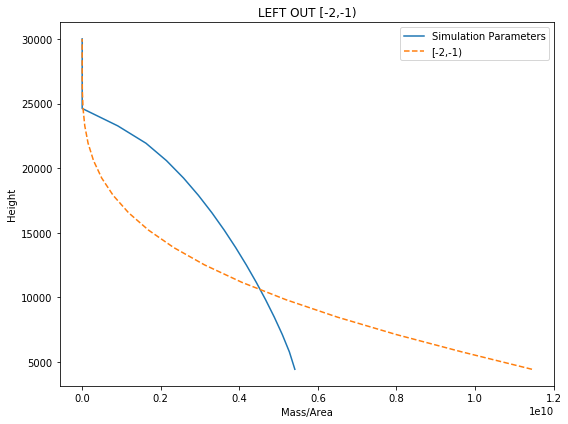

========LEFT OUT: [-1,0)========


38

a* = -3.52937	b* = 1.06768            	h1* = 2.66028
a = 1.02932	b = 3.90864	h1 = 27973.81629
Success: True, Optimization terminated successfully.
Iterations: 284
SSE: 2366.1531343225333


Height  Suspended Mass
0    4430.75    1.065053e+10
1    5776.50    9.158960e+09
2    7122.25    7.726913e+09
3    8468.00    6.417904e+09
4    9813.75    5.247245e+09
5   11159.50    4.216903e+09
6   12505.25    3.323375e+09
7   13851.00    2.560384e+09
8   15196.75    1.920030e+09
9   16542.50    1.393353e+09
10  17888.25    9.706368e+08
11  19234.00    6.415840e+08
12  20579.75    3.954128e+08
13  21925.50    2.209120e+08
14  23271.25    1.064597e+08
15  24617.00    4.000933e+07
16  25962.75    9.031466e+06
17  27308.50    3.623951e+05
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

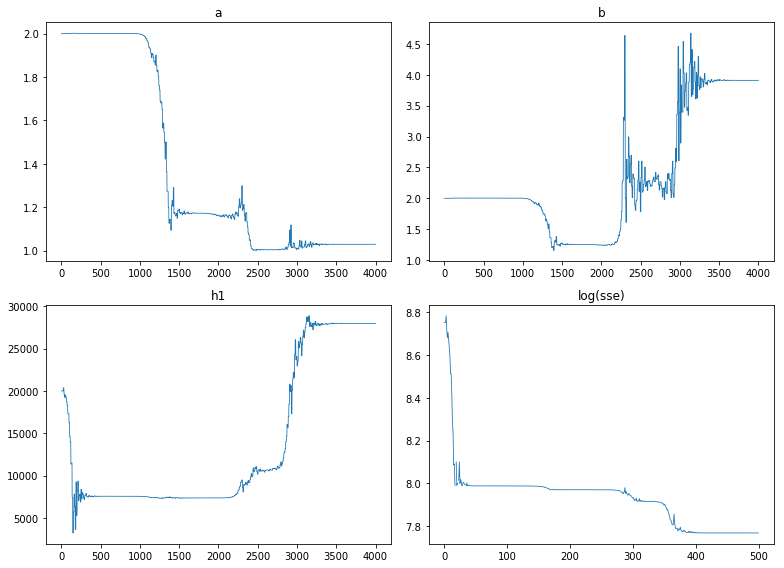

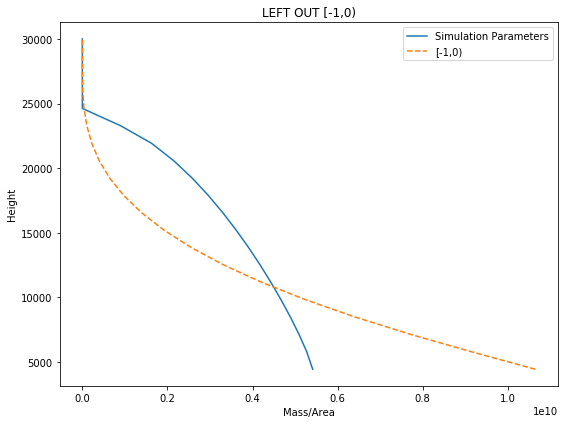

========LEFT OUT: [0,1)========


38

a* = -3.50152	b* = 0.83113            	h1* = 2.62077
a = 1.03015	b = 3.29591	h1 = 27895.07627
Success: True, Optimization terminated successfully.
Iterations: 278
SSE: 2528.9885864338294


Height  Suspended Mass
0    4430.75    9.121603e+09
1    5776.50    8.133090e+09
2    7122.25    7.128119e+09
3    8468.00    6.165359e+09
4    9813.75    5.263813e+09
5   11159.50    4.431689e+09
6   12505.25    3.672830e+09
7   13851.00    2.988882e+09
8   15196.75    2.380196e+09
9   16542.50    1.846255e+09
10  17888.25    1.385889e+09
11  19234.00    9.973746e+08
12  20579.75    6.784672e+08
13  21925.50    4.263764e+08
14  23271.25    2.376753e+08
15  24617.00    1.081088e+08
16  25962.75    3.218514e+07
17  27308.50    2.087777e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

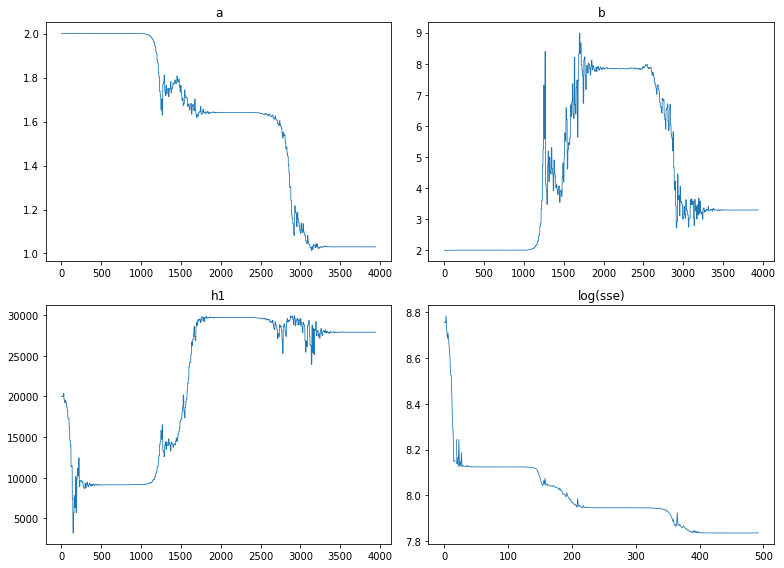

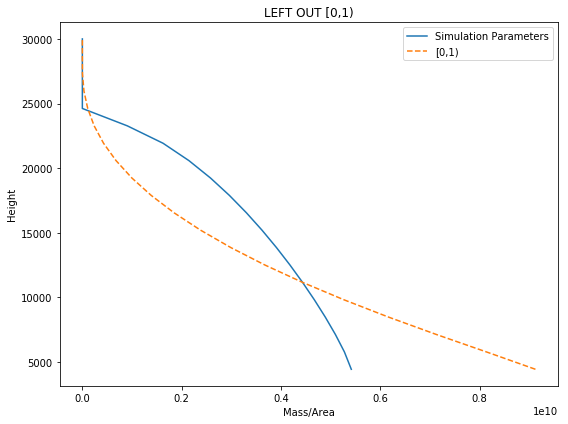

========LEFT OUT: [1,2)========


38

a* = -3.47488	b* = 0.80558            	h1* = 2.59835
a = 1.03097	b = 3.23799	h1 = 27849.11347
Success: True, Optimization terminated successfully.
Iterations: 296
SSE: 2584.8324639751013


Height  Suspended Mass
0    4430.75    8.979412e+09
1    5776.50    8.036128e+09
2    7122.25    7.068990e+09
3    8468.00    6.137308e+09
4    9813.75    5.260573e+09
5   11159.50    4.447465e+09
6   12505.25    3.702313e+09
7   13851.00    3.027268e+09
8   15196.75    2.423215e+09
9   16542.50    1.890198e+09
10  17888.25    1.427645e+09
11  19234.00    1.034466e+09
12  20579.75    7.091014e+08
13  21925.50    4.494962e+08
14  23271.25    2.530285e+08
15  24617.00    1.163340e+08
16  25962.75    3.492551e+07
17  27308.50    2.134363e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

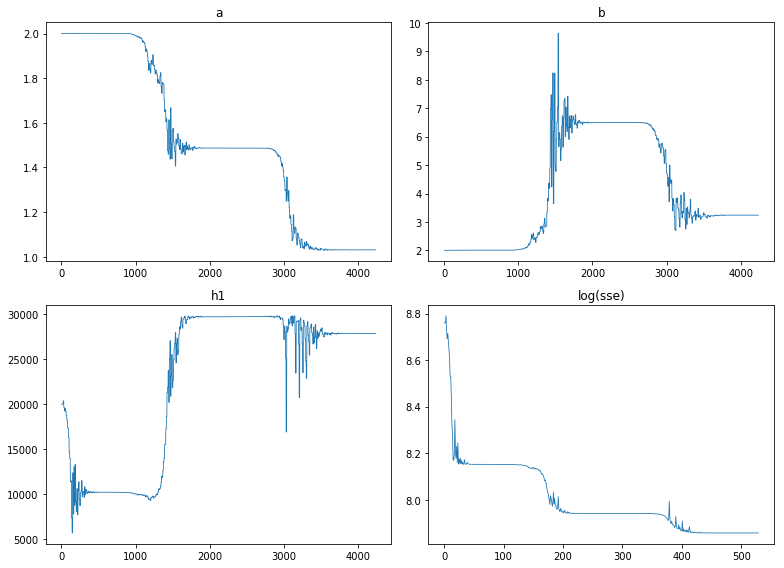

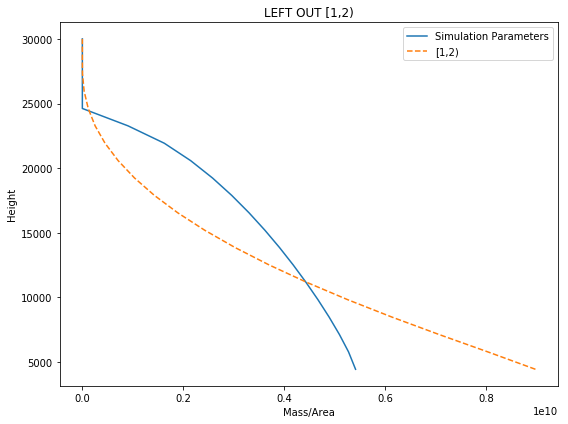

========LEFT OUT: [2,3)========


38

a* = -3.46504	b* = 0.76752            	h1* = 2.59235
a = 1.03127	b = 3.15442	h1 = 27836.65466
Success: True, Optimization terminated successfully.
Iterations: 298
SSE: 2595.3005149242645


Height  Suspended Mass
0    4430.75    8.764038e+09
1    5776.50    7.883390e+09
2    7122.25    6.971501e+09
3    8468.00    6.086708e+09
4    9813.75    5.248488e+09
5   11159.50    4.465811e+09
6   12505.25    3.743444e+09
7   13851.00    3.084078e+09
8   15196.75    2.489212e+09
9   16542.50    1.959581e+09
10  17888.25    1.495369e+09
11  19234.00    1.096330e+09
12  20579.75    7.618288e+08
13  21925.50    4.908515e+08
14  23271.25    2.819527e+08
15  24617.00    1.331349e+08
16  25962.75    4.156173e+07
17  27308.50    2.719997e+06
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

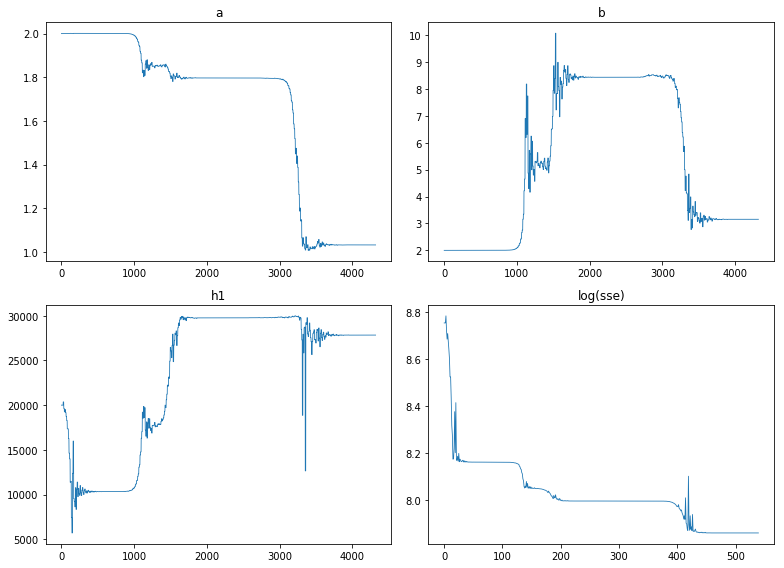

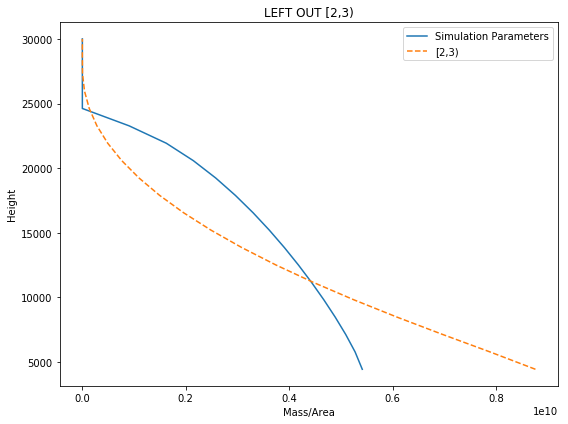

========LEFT OUT: [3,4)========


38

a* = -1.57867	b* = -0.92734            	h1* = 3.23256
a = 1.20625	b = 1.39561	h1 = 28839.35610
Success: True, Optimization terminated successfully.
Iterations: 189
SSE: 718.6247404353298


Height  Suspended Mass
0    4430.75    2.733578e+09
1    5776.50    3.083719e+09
2    7122.25    3.273887e+09
3    8468.00    3.387205e+09
4    9813.75    3.452128e+09
5   11159.50    3.481882e+09
6   12505.25    3.483529e+09
7   13851.00    3.461049e+09
8   15196.75    3.416605e+09
9   16542.50    3.351113e+09
10  17888.25    3.264473e+09
11  19234.00    3.155581e+09
12  20579.75    3.022146e+09
13  21925.50    2.860206e+09
14  23271.25    2.663086e+09
15  24617.00    2.418984e+09
16  25962.75    2.104389e+09
17  27308.50    1.659095e+09
18  28654.25    7.273454e+08
19  30000.00    0.000000e+00

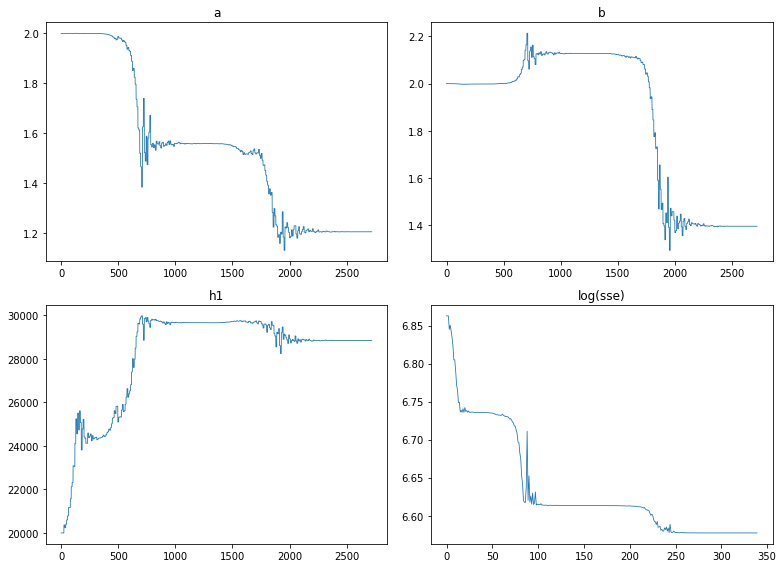

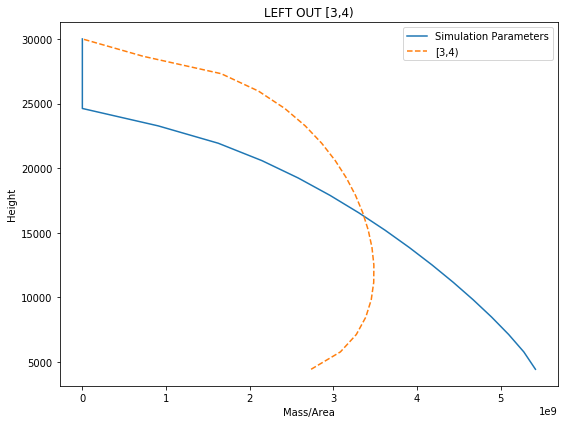

In [65]:
priors_vals = {
    "a": 2,
    "b": 2,
    "h1": 20000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)



inverted_masses_list = []
params_list = []
sse_list = []
for i, phi_step in enumerate(phi_steps):
    loo_df = df.copy()
    loo_df = loo_df.drop(phi_step["interval"], 1)
    
    print("========LEFT OUT: %s========"%(phi_step["interval"]))
    classes = phi_steps.copy()
    del classes[i]
    display(len(loo_df))
    out = gaussian_stack_inversion(
        loo_df, len(loo_df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        classes, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_dist = beta(config["ALPHA"],config["BETA"])

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("LEFT OUT %s"%(phi_step["interval"]))
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

Grain Size Removed         a         b  Column Height  Goodness of Fit
0           (-5, -4)  1.031140  3.109804   27731.061081      2490.257831
1           (-4, -3)  1.031179  3.302939   27684.172576      2427.137591
2           (-3, -2)  1.030910  3.768073   27701.961330      2226.000290
3           (-2, -1)  1.030116  4.221042   27880.696379      2218.652242
4            (-1, 0)  1.029323  3.908637   27973.816291      2366.153134
5             (0, 1)  1.030152  3.295907   27895.076266      2528.988586
6             (1, 2)  1.030966  3.237990   27849.113469      2584.832464
7             (2, 3)  1.031272  3.154420   27836.654658      2595.300515
8             (3, 4)  1.206249  1.395606   28839.356105       718.624740

\begin{tabular}{lrrrr}
\toprule
Grain Size Removed &    a &    b &  Column Height &  Goodness of Fit \\
\midrule
          (-5, -4) & 1.03 & 3.11 &       27731.06 &          2490.26 \\
          (-4, -3) & 1.03 & 3.30 &       27684.17 &          2427.14 \\
          (-3, -2) & 1.03 & 3.77 &       27701.96 &          2226.00 \\
          (-2, -1) & 1.03 & 4.22 &       27880.70 &          2218.65 \\
           (-1, 0) & 1.03 & 3.91 &       27973.82 &          2366.15 \\
            (0, 1) & 1.03 & 3.30 &       27895.08 &          2528.99 \\
            (1, 2) & 1.03 & 3.24 &       27849.11 &          2584.83 \\
            (2, 3) & 1.03 & 3.15 &       27836.65 &          2595.30 \\
            (3, 4) & 1.21 & 1.40 &       28839.36 &           718.62 \\
\bottomrule
\end{tabular}



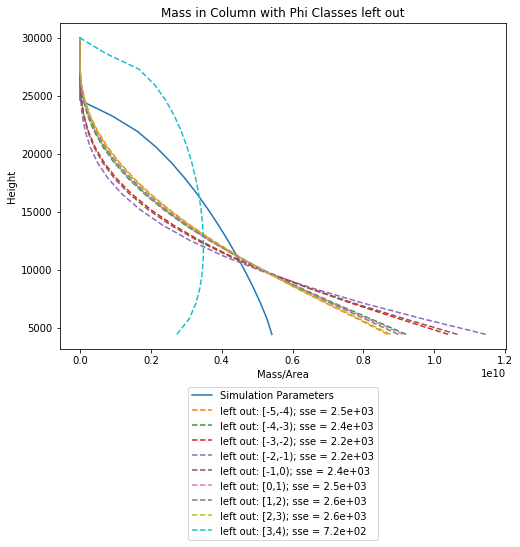

In [69]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

table = pd.DataFrame(columns=[
    "Grain Size Removed", 
    "a", 
    "b", 
    "Column Height", 
    "Goodness of Fit"
])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for i, phi_step, mass, sse in zip(list(range(len(phi_steps))), phi_steps, inverted_masses_list, sse_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="left out: %s; sse = %.2g"%(phi_step["interval"], sse))
    table = table.append({
        "Grain Size Removed": "(%.2g, %.2g)"%(phi_step["lower"], phi_step["upper"]),
        "a": params_list[i]["a"],
        "b": params_list[i]["b"],
        "Column Height": params_list[i]["h1"],
        "Goodness of Fit": sse,
    }, ignore_index=True)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column with Phi Classes left out")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
# plt.show()
plt.savefig("data/colima/GS_CV_%s_%s.png"%(file_tag, err_type), dpi=300, bbox_inches='tight')
display(table)
print(table.to_latex(index=False, float_format="%.2f"))
file = open("data/colima/GS_CV_%s_%s.tex"%(file_tag, err_type), "w")
file.write(table.to_latex(index=False, float_format="%.2f"))
file.close()

In [19]:
n = 5
p = 6
q = 4

A = np.random.rand(n, p, q)
Q = np.random.rand(q, p, 1)
print(A.shape)
print(Q.shape)

print(A)

print(Q)

# M = np.tensordot(A, Q, (2, 1))
M2 = np.einsum('ijk,kj', A, Q)

print(M.shape)

(5, 6, 4)
(4, 6, 1)
[[[0.93276371 0.70141305 0.56929049 0.17925869]
  [0.39452013 0.3068375  0.21044413 0.38959527]
  [0.62037857 0.58946495 0.80734608 0.96344297]
  [0.47994704 0.41546623 0.49889807 0.24660947]
  [0.94839495 0.74234802 0.50688089 0.23038686]
  [0.65476827 0.75984915 0.01492437 0.66426102]]

 [[0.23727879 0.88187241 0.91576369 0.22164052]
  [0.2679288  0.41087065 0.16517367 0.07966052]
  [0.74447767 0.65482222 0.83838378 0.57558261]
  [0.96177508 0.50484174 0.62484774 0.36600208]
  [0.70051461 0.91707264 0.88341711 0.58612998]
  [0.78918009 0.56804403 0.25503689 0.29249366]]

 [[0.90063257 0.5090191  0.29189023 0.84290854]
  [0.17162361 0.11518165 0.88707006 0.92227756]
  [0.03654251 0.3990366  0.40018034 0.37148344]
  [0.14731847 0.44141306 0.04357123 0.67043383]
  [0.57236806 0.97570936 0.25527673 0.26690271]
  [0.11548889 0.51598894 0.5364067  0.8818888 ]]

 [[0.27066901 0.77441966 0.35653648 0.93152646]
  [0.35978114 0.49047171 0.5836883  0.49130382]
  [0.75354458 

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.